In [6]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import tables as tb
from astropy.coordinates.angle_utilities import angular_separation
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from astropy.table import Table, Column
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

In [2]:
def extract_df(root_filename):
    particle_file = uproot.open(root_filename)
    data = particle_file["data"]
    cuts = particle_file["fEventTreeCuts"]

    # Cut 1: Events surviving gamma/hadron separation and direction cuts:
    mask_gamma_like_and_direction = cuts.array('CutClass') == 5

    # Cut 2: Events surviving gamma/hadron separation cut and not direction cut:
    mask_gamma_like_no_direction = cuts.array('CutClass') == 0

    gamma_like_events = np.logical_or(mask_gamma_like_and_direction, mask_gamma_like_no_direction)
    mc_energy = data.array("MCe0")[gamma_like_events]  # mc_energy = tb.Float32Col(dflt=np.nan, pos=7)

    # Variables for regression:
    mc_alt = 90 - data.array("MCze")[gamma_like_events]
    mc_az = data.array("MCaz")[gamma_like_events]
    reco_alt = 90 - data.array("Ze")[gamma_like_events]  # reco_alt = tb.Float32Col(dflt=np.nan, pos=9)
    reco_az = data.array("Az")[gamma_like_events]  # reco_az = tb.Float32Col(dflt=np.nan, pos=10)
    # Angular separation bewteen the true vs reconstructed direction
    ang_diff = angular_separation(
        mc_az * u.deg,  # az
        mc_alt * u.deg,  # alt
        reco_az * u.deg,
        reco_alt * u.deg,
    )

    # Variables for training:
    av_size = [np.average(sizes) for sizes in data.array("size")[gamma_like_events]]       
    reco_energy = data.array("ErecS")[gamma_like_events]  
    NTels_reco = data.array("NImages")[gamma_like_events]
    x_cores = data.array('Xcore')[gamma_like_events]
    y_cores = data.array('Ycore')[gamma_like_events]
    array_distance = np.sqrt(x_cores**2. + y_cores**2.)
    x_off = data.array('Xoff')[gamma_like_events]
    y_off = data.array('Yoff')[gamma_like_events]
    camera_offset = np.sqrt(x_off**2. + y_off**2.)
    img2_ang = data.array('img2_ang')[gamma_like_events]
    EChi2S = data.array('EChi2S')[gamma_like_events]
    SizeSecondMax = data.array('SizeSecondMax')[gamma_like_events]
    NTelPairs = data.array('NTelPairs')[gamma_like_events]
    MSCW = data.array('MSCW')[gamma_like_events]
    MSCL = data.array('MSCL')[gamma_like_events]
    # Bin in reconstructed energy, and calculate percentiles (in this case 4 event types):
    event_types = np.zeros_like(reco_energy)
    log_e_reco_bins = np.linspace(-2., 2.5, 40)
    for i, log_e_high in enumerate(log_e_reco_bins):
        if i is 0:
            continue
        e_low = 10**log_e_reco_bins[i-1]
        e_high = 10**log_e_high
        # Select events within the rec. energy bin:
        events = np.logical_and(reco_energy > e_low, reco_energy < e_high)
        # Make sure there are events:
        if not np.sum(events) > 0:
            continue
        p1 = np.percentile(ang_diff[events], 25)
        p2 = np.percentile(ang_diff[events], 50)
        p3 = np.percentile(ang_diff[events], 75)
        event_types[np.logical_and(events, ang_diff < p1)] = 0
        event_types[np.logical_and(np.logical_and(events, ang_diff >= p1), ang_diff < p2)] = 1
        event_types[np.logical_and(np.logical_and(events, ang_diff >= p2), ang_diff < p3)] = 2
        event_types[np.logical_and(events, ang_diff >= p3)] = 3
    # Build astropy table:
    t = Table()
#     t['log_ang_diff'] = np.log10(ang_diff.value)
    # t['log_av_size'] = np.log10(av_size)
    t['log_reco_energy'] = np.log10(reco_energy)
    t['log_NTels_reco'] = np.log10(NTels_reco)
    t['array_distance'] = array_distance
    t['img2_ang'] = img2_ang
    # t['log_EChi2S'] = np.log10(EChi2S)
    t['log_SizeSecondMax'] = np.log10(SizeSecondMax)
#     t['camera_offset'] = camera_offset
    # t['log_NTelPairs'] = np.log10(NTelPairs)
    # t['MSCW'] = MSCW
    # t['MSCL'] = MSCL
    t['event_types'] = event_types
    return t.to_pandas()

In [3]:
dtf = extract_df("gamma_onSource.S.3HB9-FD_ID0.eff-0.root")
# dtf = extract_df("gamma_cone.S.3HB9-FD_ID0.eff-1.root")


In [4]:
train_feature = "event_types"
result_scores = dict()

In [7]:
## split data
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.85)## print info
X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
           'img2_ang', 'log_SizeSecondMax']
X_train = dtf_train[X_names].values
y_train = dtf_train[train_feature].values
X_test = dtf_test[X_names].values
y_test = dtf_test[train_feature].values

print("X_train shape:", dtf_train.drop(train_feature,axis=1).shape, "| X_test shape:", 
      dtf_test.drop(train_feature,axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train[train_feature]),2), "| y_test mean:", 
      round(np.mean(dtf_test[train_feature]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop(train_feature,axis=1).columns.to_list())

X_train shape: (280103, 5) | X_test shape: (1587252, 5)
y_train mean: 1.5 | y_test mean: 1.5
6 features: ['log_reco_energy', 'log_NTels_reco', 'array_distance', 'img2_ang', 'log_SizeSecondMax']


In [26]:
## scale X
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X = scalerX.fit_transform(dtf_train.drop(train_feature, axis=1))
dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop(train_feature, 
                                                   axis=1).columns, index=dtf_train.index)## scale Y
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
dtf_scaled[train_feature] = scalerY.fit_transform(dtf_train[train_feature].values.reshape(-1,1))
dtf_scaled.head()

,log_reco_energy,log_NTels_reco,array_distance,img2_ang,log_SizeSecondMax,camera_offset,event_types
1703630,-0.694794,-0.678072,-0.477741,-1.141977,0.027476,2.994357,0.333333
1290395,0.091596,0.000000,0.439219,0.601387,-0.262925,-0.419748,-0.666667
424883,-0.008037,0.321928,0.203887,0.398638,-0.237204,0.377744,0.333333
1389976,-0.807546,-1.000000,-0.232839,-5.065455,-0.963759,7.303369,0.333333
1397778,-0.437203,0.000000,-0.381051,-0.314703,0.308877,0.165185,-0.333333


Text(0.5, 1.0, 'pearson correlation')

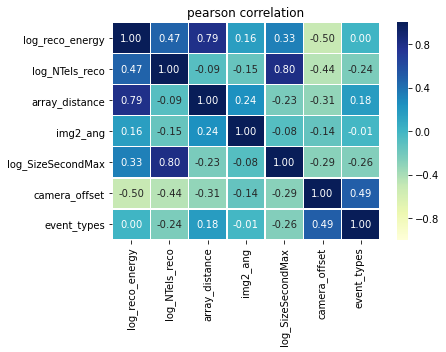

In [27]:
corr_matrix = dtf_train.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

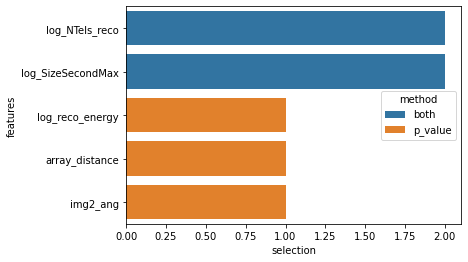

In [8]:
X = dtf_train.drop(train_feature, axis=1).values
y = dtf_train[train_feature].values
feature_names = dtf_train.drop(train_feature, axis=1).columns## p-value
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_regression, k=5).fit(X,y)
pvalue_selected_features = feature_names[selector.get_support()]

## regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.Ridge(alpha=1.0, fit_intercept=True), 
                                 max_features=5).fit(X,y)
regularization_selected_features = feature_names[selector.get_support()]
 
## plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["p_value"] = dtf_features["features"].apply(
    lambda x: "p_value" if x in pvalue_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(
    lambda x: 1 if x in pvalue_selected_features else 0)
dtf_features["regularization"] = dtf_features["features"].apply(
    lambda x: "regularization" if x in regularization_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(
    lambda x: 1 if x in regularization_selected_features else 0)
dtf_features["method"] = dtf_features[["p_value","regularization"]].apply(
    lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
dtf_features["method"] = dtf_features["method"].apply(
    lambda x: "both" if len(x.split()) == 2 else x)

sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", 
                                                                                     ascending=False), 
            dodge=False)

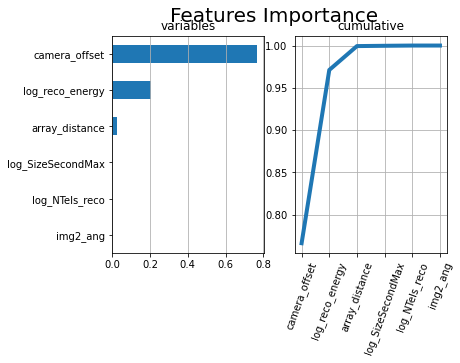

In [29]:
X = dtf_train.drop(train_feature, axis=1).values
y = dtf_train[train_feature].values
feature_names = dtf_train.drop(train_feature, axis=1).columns.tolist()## call model
model = ensemble.GradientBoostingRegressor()## Importance
model.fit(X,y)
importances = model.feature_importances_## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

In [34]:
["{}".format(a) for a in np.arange(0,4,1)]

['0', '1', '2', '3']

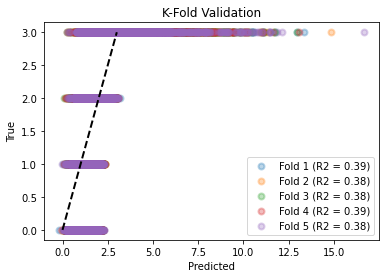

In [32]:
## call model
model = linear_model.LinearRegression()## K fold validation
scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.6s finished


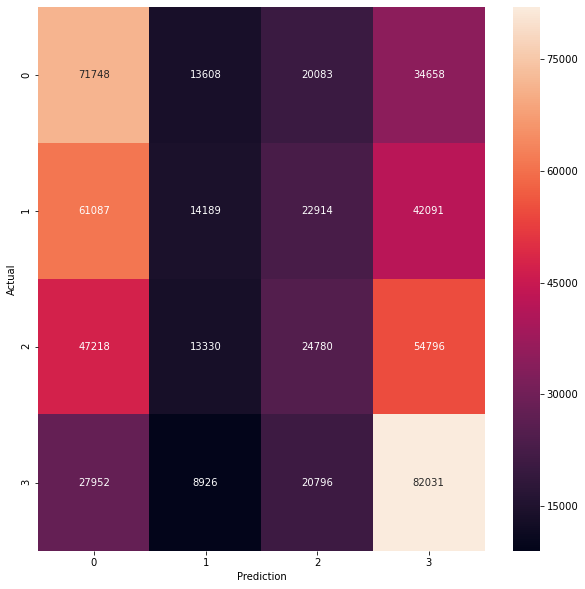

In [37]:
# importing necessary libraries 
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
  
# dividing X, y into train and test data 
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 
  
# training a DescisionTreeClassifier 
RandomForestRegressor

dtree_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=0, 
                                     verbose=True).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, dtree_predictions) 
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=["{}".format(a) for a in np.arange(0,4,1)], 
            yticklabels=["{}".format(a) for a in np.arange(0,4,1)])
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.show()

In [18]:
dtree_predictions

array([4., 1., 4., ..., 4., 1., 4.])

In [39]:
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.85)## print info

train_feature = "event_types"
X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
           'img2_ang', 'log_SizeSecondMax']
X_train = dtf_train[X_names].values
y_train = dtf_train[train_feature].values
X_test = dtf_test[X_names].values
y_test = dtf_test[train_feature].values

y_tr = y_train
X_tr = X_train
X_test = X_test
y_test = y_test

In [40]:
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000).fit(X_tr, y_tr)
LR.predict(X_test)
print(round(LR.score(X_test,y_test), 4))

RF = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, n_jobs=4).fit(X_tr, y_tr)
RF.predict(X_test)
print(round(RF.score(X_test, y_test), 4))

NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), 
                   random_state=1,max_iter=10000).fit(X_tr, y_tr)
NN.predict(X_test)
print(round(NN.score(X_test, y_test), 4))

0.3308
0.3431
0.2498


In [41]:
RF = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, 
                            random_state=0, n_jobs=4).fit(X_tr, y_tr)
RF.predict(X_test)
print(round(RF.score(X_test, y_test), 4))

0.3174


In [ ]:
GBC = GradientBoostingClassifier(n_estimators=100, max_depth=10, 
                                 learning_rate=1.0, verbose=True).fit(X_tr, y_tr)
GBC.predict(X_test)
print(round(GBC.score(X_test, y_test), 4))

      Iter       Train Loss   Remaining Time 
         1     1226203.6706           43.71m
         2     1215735.4039           46.91m
         3     1210936.7471           49.85m
         4     1208279.0064           48.37m
         5     1205623.6623           47.30m
         6     1202936.1571           46.41m
         7     1200125.4149           45.21m


In [14]:
LR2 = LogisticRegression(solver='liblinear', multi_class='ovr').fit(X_tr, y_tr)
LR2.predict(X_test)
print(round(LR2.score(X_test, y_test), 4))

LDA = LinearDiscriminantAnalysis().fit(X_tr, y_tr)
LDA.predict(X_test)
print(round(LDA.score(X_test, y_test), 4))

KNC = KNeighborsClassifier().fit(X_tr, y_tr)
KNC.predict(X_test)
print(round(KNC.score(X_test, y_test), 4))

DTC = DecisionTreeClassifier().fit(X_tr, y_tr)
DTC.predict(X_test)
print(round(DTC.score(X_test, y_test), 4))

GNB = GaussianNB().fit(X_tr, y_tr)
GNB.predict(X_test)
print(round(GNB.score(X_test, y_test), 4))

0.2957
0.2961
0.2616
0.271
0.2705


In [15]:
bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1).fit(X_tr, y_tr)
bdt_real.predict(X_test)
print(round(bdt_real.score(X_test, y_test), 4))

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME").fit(X_tr, y_tr)
bdt_discrete.predict(X_test)
print(round(bdt_discrete.score(X_test, y_test), 4))

0.3019
0.3015


This one takes fucking ages to train...

In [ ]:
SVML = svm.SVC(kernel="linear", cache_size=7000, verbose=True).fit(X_tr, y_tr)
SVML.predict(X_test)
print(round(SVML.score(X_test, y_test), 4))

In [ ]:
SVM = svm.SVC(decision_function_shape="ovo", cache_size=7000, verbose=True).fit(X_tr, y_tr)
SVM.predict(X_test)
print(round(SVM.score(X_test, y_test), 4))

In [17]:
mask = np.logical_and(dtf['log_reco_energy'] > 0.5, 
                      dtf['log_reco_energy'] < 0.7)
this_dtf = dtf[mask]
len(this_dtf)

103988

0.0 0
0.010 < E < 0.017 -- Score: 0.3067
0.0 1
0.017 < E < 0.030 -- Score: 0.2848
0.0 2
0.030 < E < 0.051 -- Score: 0.2946
0.0 3
0.051 < E < 0.089 -- Score: 0.2945
1.0 0
0.089 < E < 0.153 -- Score: 0.2866
1.0 1
0.153 < E < 0.264 -- Score: 0.2849
1.0 2
0.264 < E < 0.455 -- Score: 0.2872
1.0 3
0.455 < E < 0.785 -- Score: 0.2976
2.0 0
0.785 < E < 1.354 -- Score: 0.3291
2.0 1
1.354 < E < 2.336 -- Score: 0.3694
2.0 2
2.336 < E < 4.030 -- Score: 0.3702
2.0 3
4.030 < E < 6.952 -- Score: 0.3655
3.0 0
6.952 < E < 11.994 -- Score: 0.3645
3.0 1
11.994 < E < 20.691 -- Score: 0.3551
3.0 2
20.691 < E < 35.697 -- Score: 0.355
3.0 3
35.697 < E < 61.585 -- Score: 0.3576
4.0 0
61.585 < E < 106.247 -- Score: 0.3603
4.0 1
106.247 < E < 183.298 -- Score: 0.3444
4.0 2
183.298 < E < 316.228 -- Score: 0.32


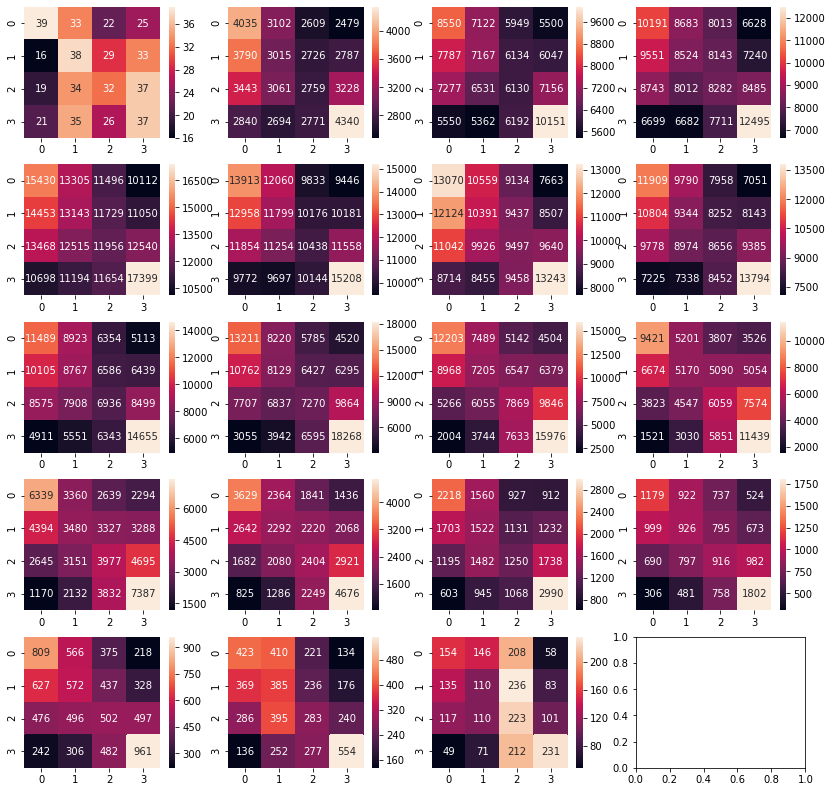

In [9]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[14, 14])
# Plot
log_e_reco_bins = np.linspace(-2., 2.5, 20)
rf_scores = []
for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue

    mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                          dtf['log_reco_energy'] < log_e_high)
    this_dtf = dtf[mask]
    if not len(this_dtf) > 0:
        continue
        
    print(np.floor((i-1)/4)%5, (i-1)%4)
    ax = axs[int(np.floor((i-1)/4)%5), (i-1)%4]
    
    dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

    X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
               'img2_ang', 'log_SizeSecondMax']
    X_train = dtf_train[X_names].values
    y_train = dtf_train[train_feature].values
    X_test = dtf_test[X_names].values
    y_test = dtf_test[train_feature].values

    # dividing X, y into train and test data 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

    # training a DescisionTreeClassifier 
    dtree_model = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=0, 
                                         n_jobs=4).fit(X_train, y_train) 
    dtree_predictions = dtree_model.predict(X_test) 
    score = round(dtree_model.score(X_test, y_test), 4)
    print("{:3.3f} < E < {:3.3f} -- Score: {}".format(10**log_e_reco_bins[i-1],
                                                      10**log_e_high,
                                                      score))
    rf_scores.append(score)
    
    # creating a confusion matrix 
    cm = confusion_matrix(y_test, dtree_predictions) 
    sns.heatmap(cm, annot=True, fmt='d', ax=ax,
                xticklabels=["{}".format(a) for a in np.arange(0,4,1)], 
                yticklabels=["{}".format(a) for a in np.arange(0,4,1)])
plt.show()
result_scores['RandomForestClassifier_50'] = rf_scores.copy()

0.0 0
0.010 < E < 0.017 -- Score: 0.2647
0.0 1
0.017 < E < 0.030 -- Score: 0.2856
0.0 2
0.030 < E < 0.051 -- Score: 0.2967
0.0 3
0.051 < E < 0.089 -- Score: 0.2953
1.0 0
0.089 < E < 0.153 -- Score: 0.2903
1.0 1
0.153 < E < 0.264 -- Score: 0.2862
1.0 2
0.264 < E < 0.455 -- Score: 0.2858
1.0 3
0.455 < E < 0.785 -- Score: 0.3003
2.0 0
0.785 < E < 1.354 -- Score: 0.3285
2.0 1
1.354 < E < 2.336 -- Score: 0.3707
2.0 2
2.336 < E < 4.030 -- Score: 0.3765
2.0 3
4.030 < E < 6.952 -- Score: 0.3713
3.0 0
6.952 < E < 11.994 -- Score: 0.3657
3.0 1
11.994 < E < 20.691 -- Score: 0.3646
3.0 2
20.691 < E < 35.697 -- Score: 0.3661
3.0 3
35.697 < E < 61.585 -- Score: 0.3583
4.0 0
61.585 < E < 106.247 -- Score: 0.356
4.0 1
106.247 < E < 183.298 -- Score: 0.3475
4.0 2
183.298 < E < 316.228 -- Score: 0.316


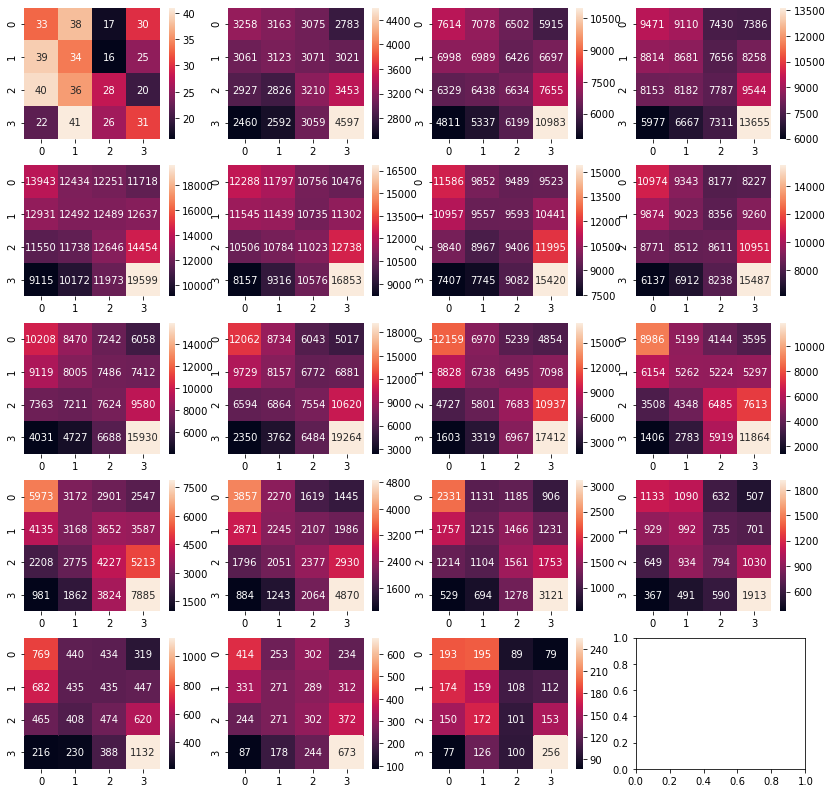

In [10]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[14, 14])
# Plot
log_e_reco_bins = np.linspace(-2., 2.5, 20)
rf_scores = []
for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue

    mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                          dtf['log_reco_energy'] < log_e_high)
    this_dtf = dtf[mask]
    if not len(this_dtf) > 0:
        continue
        
    print(np.floor((i-1)/4)%5, (i-1)%4)
    ax = axs[int(np.floor((i-1)/4)%5), (i-1)%4]
    
    dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

    X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
               'img2_ang', 'log_SizeSecondMax']
    X_train = dtf_train[X_names].values
    y_train = dtf_train[train_feature].values
    X_test = dtf_test[X_names].values
    y_test = dtf_test[train_feature].values

    # dividing X, y into train and test data 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

    # training a DescisionTreeClassifier 
    dtree_model = OneVsRestClassifier(RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=0, 
                                                             n_jobs=6)).fit(X_train, y_train) 
    dtree_predictions = dtree_model.predict(X_test) 
    score = round(dtree_model.score(X_test, y_test), 4)
    print("{:3.3f} < E < {:3.3f} -- Score: {}".format(10**log_e_reco_bins[i-1],
                                                      10**log_e_high,
                                                      score))
    rf_scores.append(score)
    
    # creating a confusion matrix 
    cm = confusion_matrix(y_test, dtree_predictions) 
    sns.heatmap(cm, annot=True, fmt='d', ax=ax,
                xticklabels=["{}".format(a) for a in np.arange(0,4,1)], 
                yticklabels=["{}".format(a) for a in np.arange(0,4,1)])
plt.show()
result_scores['OneVsRestClassifier_RandomForestClassifier_50'] = rf_scores.copy()

0.0 0
0.010 < E < 0.017 -- Score: 0.2542
0.0 1
0.017 < E < 0.030 -- Score: 0.2916
0.0 2
0.030 < E < 0.051 -- Score: 0.3036
0.0 3
0.051 < E < 0.089 -- Score: 0.3012
1.0 0
0.089 < E < 0.153 -- Score: 0.2927
1.0 1
0.153 < E < 0.264 -- Score: 0.2918
1.0 2
0.264 < E < 0.455 -- Score: 0.2927
1.0 3
0.455 < E < 0.785 -- Score: 0.3047
2.0 0
0.785 < E < 1.354 -- Score: 0.3372
2.0 1
1.354 < E < 2.336 -- Score: 0.3753
2.0 2
2.336 < E < 4.030 -- Score: 0.3819
2.0 3
4.030 < E < 6.952 -- Score: 0.3737
3.0 0
6.952 < E < 11.994 -- Score: 0.3723
3.0 1
11.994 < E < 20.691 -- Score: 0.3635
3.0 2
20.691 < E < 35.697 -- Score: 0.3709
3.0 3
35.697 < E < 61.585 -- Score: 0.3607
4.0 0
61.585 < E < 106.247 -- Score: 0.3562
4.0 1
106.247 < E < 183.298 -- Score: 0.3448
4.0 2
183.298 < E < 316.228 -- Score: 0.3373


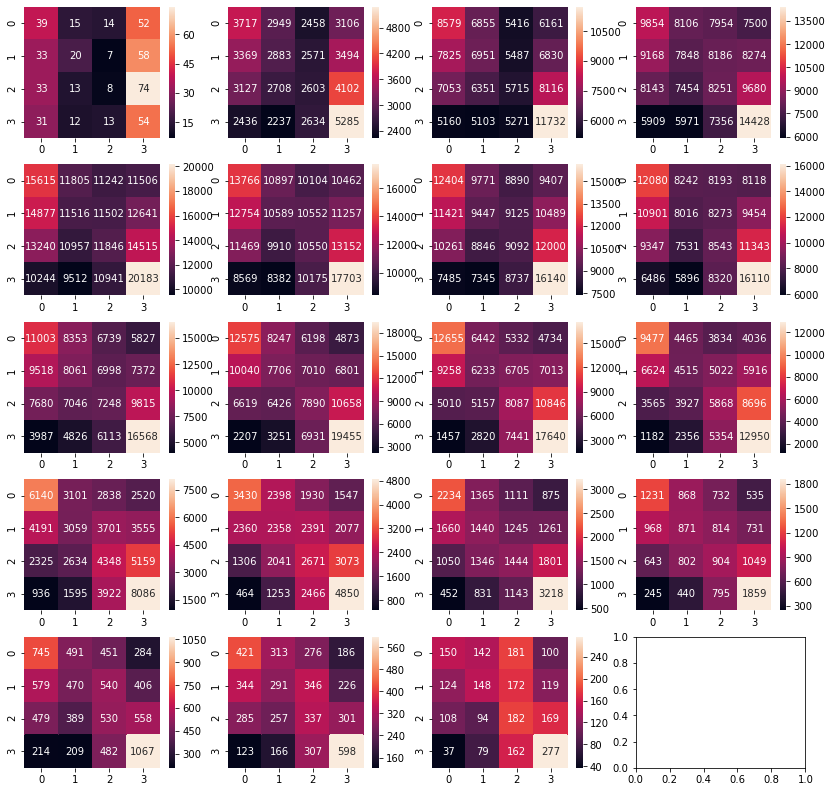

In [16]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[14, 14])
# Plot
log_e_reco_bins = np.linspace(-2., 2.5, 20)
rf_scores = []
for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue

    mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                          dtf['log_reco_energy'] < log_e_high)
    this_dtf = dtf[mask]
    if not len(this_dtf) > 0:
        continue
        
    print(np.floor((i-1)/4)%5, (i-1)%4)
    ax = axs[int(np.floor((i-1)/4)%5), (i-1)%4]
    
    dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

    X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
               'img2_ang', 'log_SizeSecondMax']
    X_train = dtf_train[X_names].values
    y_train = dtf_train[train_feature].values
    X_test = dtf_test[X_names].values
    y_test = dtf_test[train_feature].values

    # dividing X, y into train and test data 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

    # training a DescisionTreeClassifier 
    dtree_model = OneVsOneClassifier(RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, random_state=0, 
                                                             n_jobs=8)).fit(X_train, y_train) 
    dtree_predictions = dtree_model.predict(X_test) 
    score = round(dtree_model.score(X_test, y_test), 4)
    print("{:3.3f} < E < {:3.3f} -- Score: {}".format(10**log_e_reco_bins[i-1],
                                                      10**log_e_high,
                                                      score))
    rf_scores.append(score)
    
    # creating a confusion matrix 
    cm = confusion_matrix(y_test, dtree_predictions) 
    sns.heatmap(cm, annot=True, fmt='d', ax=ax,
                xticklabels=["{}".format(a) for a in np.arange(0,4,1)], 
                yticklabels=["{}".format(a) for a in np.arange(0,4,1)])
plt.show()
result_scores['OneVsOneClassifier_RandomForestClassifier_200'] = rf_scores.copy()

In [5]:
cm

NameError: name 'cm' is not defined

0.0 0
0.010 < E < 0.017 -- Score: 0.2395
0.0 1
0.017 < E < 0.030 -- Score: 0.2872
0.0 2
0.030 < E < 0.051 -- Score: 0.2962
0.0 3
0.051 < E < 0.089 -- Score: 0.2986
1.0 0
0.089 < E < 0.153 -- Score: 0.2907
1.0 1
0.153 < E < 0.264 -- Score: 0.2879
1.0 2
0.264 < E < 0.455 -- Score: 0.2897
1.0 3
0.455 < E < 0.785 -- Score: 0.3053
2.0 0
0.785 < E < 1.354 -- Score: 0.3341
2.0 1
1.354 < E < 2.336 -- Score: 0.3767
2.0 2
2.336 < E < 4.030 -- Score: 0.3778
2.0 3
4.030 < E < 6.952 -- Score: 0.3707
3.0 0
6.952 < E < 11.994 -- Score: 0.3686
3.0 1
11.994 < E < 20.691 -- Score: 0.3587
3.0 2
20.691 < E < 35.697 -- Score: 0.3672
3.0 3
35.697 < E < 61.585 -- Score: 0.3592
4.0 0
61.585 < E < 106.247 -- Score: 0.3648
4.0 1
106.247 < E < 183.298 -- Score: 0.3617
4.0 2
183.298 < E < 316.228 -- Score: 0.3405


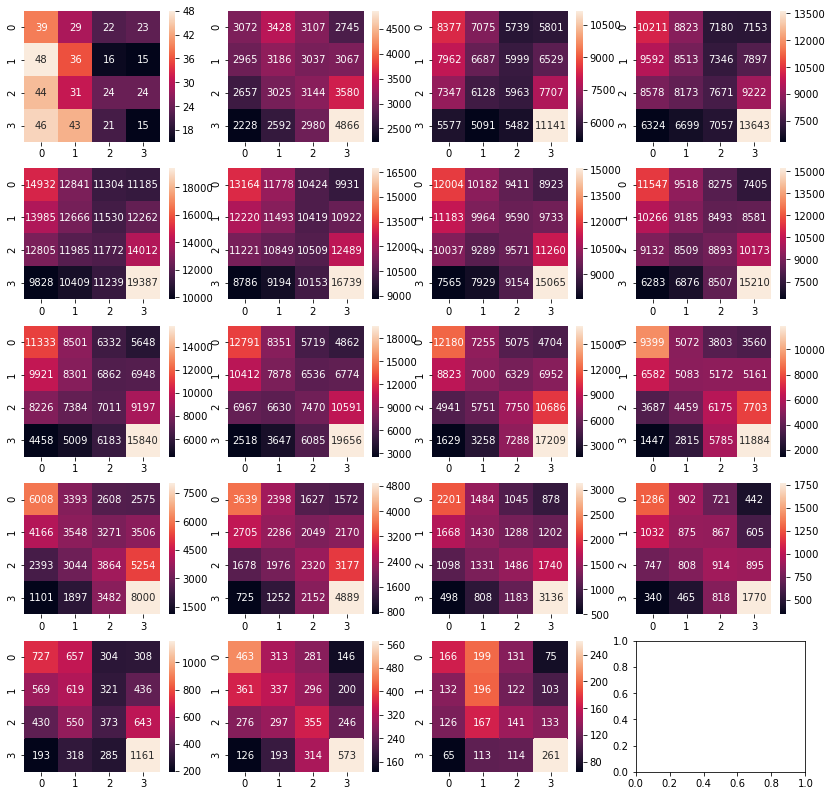

In [17]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[14, 14])
# Plot
log_e_reco_bins = np.linspace(-2., 2.5, 20)
rf_scores = []
for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue

    mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                          dtf['log_reco_energy'] < log_e_high)
    this_dtf = dtf[mask]
    if not len(this_dtf) > 0:
        continue
        
    print(np.floor((i-1)/4)%5, (i-1)%4)
    ax = axs[int(np.floor((i-1)/4)%5), (i-1)%4]
    
    dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

    X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
               'img2_ang', 'log_SizeSecondMax']
    X_train = dtf_train[X_names].values
    y_train = dtf_train[train_feature].values
    X_test = dtf_test[X_names].values
    y_test = dtf_test[train_feature].values

    # dividing X, y into train and test data 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

    # training a DescisionTreeClassifier 
    dtree_model = OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, random_state=0, 
                                                             n_jobs=8)).fit(X_train, y_train) 
    dtree_predictions = dtree_model.predict(X_test) 
    score = round(dtree_model.score(X_test, y_test), 4)
    print("{:3.3f} < E < {:3.3f} -- Score: {}".format(10**log_e_reco_bins[i-1],
                                                      10**log_e_high,
                                                      score))
    rf_scores.append(score)
    
    # creating a confusion matrix 
    cm = confusion_matrix(y_test, dtree_predictions) 
    sns.heatmap(cm, annot=True, fmt='d', ax=ax,
                xticklabels=["{}".format(a) for a in np.arange(0,4,1)], 
                yticklabels=["{}".format(a) for a in np.arange(0,4,1)])
plt.show()
result_scores['OneVsOneClassifier_RandomForestClassifier_200'] = rf_scores.copy()

In [6]:
for n_estimators in [100, 200, 300]:
    log_e_reco_bins = np.linspace(-2., 2.5, 20)
    rf_scores = []
    for i, log_e_high in enumerate(log_e_reco_bins):
        if i is 0:
            continue

        mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                              dtf['log_reco_energy'] < log_e_high)
        this_dtf = dtf[mask]
        if not len(this_dtf) > 0:
            continue

        print(np.floor((i-1)/4)%5, (i-1)%4)

        dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

        X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
                   'img2_ang', 'log_SizeSecondMax']
        X_train = dtf_train[X_names].values
        y_train = dtf_train[train_feature].values
        X_test = dtf_test[X_names].values
        y_test = dtf_test[train_feature].values

        # dividing X, y into train and test data 
        # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

        # training a DescisionTreeClassifier 
        dtree_model = OneVsOneClassifier(RandomForestClassifier(n_estimators=n_estimators, max_depth=None, min_samples_split=2, random_state=0, 
                                                                n_jobs=4)).fit(X_train, y_train) 
        dtree_predictions = dtree_model.predict(X_test) 
        score = round(dtree_model.score(X_test, y_test), 4)
        print("{:3.3f} < E < {:3.3f} -- Score: {}".format(10**log_e_reco_bins[i-1],
                                                          10**log_e_high,
                                                          score))
        rf_scores.append(score)

    result_scores['OneVsOneClassifier_RandomForestClassifier_{}'.format(n_estimators)] = rf_scores.copy()

0.0 0
0.010 < E < 0.017 -- Score: 0.2626
0.0 1
0.017 < E < 0.030 -- Score: 0.2909
0.0 2
0.030 < E < 0.051 -- Score: 0.3005
0.0 3
0.051 < E < 0.089 -- Score: 0.2993
1.0 0
0.089 < E < 0.153 -- Score: 0.2905
1.0 1
0.153 < E < 0.264 -- Score: 0.2908
1.0 2
0.264 < E < 0.455 -- Score: 0.2926
1.0 3
0.455 < E < 0.785 -- Score: 0.3034
2.0 0
0.785 < E < 1.354 -- Score: 0.3342
2.0 1
1.354 < E < 2.336 -- Score: 0.3778
2.0 2
2.336 < E < 4.030 -- Score: 0.3812
2.0 3
4.030 < E < 6.952 -- Score: 0.3738
3.0 0
6.952 < E < 11.994 -- Score: 0.3712
3.0 1
11.994 < E < 20.691 -- Score: 0.3634
3.0 2
20.691 < E < 35.697 -- Score: 0.3744
3.0 3
35.697 < E < 61.585 -- Score: 0.3676
4.0 0
61.585 < E < 106.247 -- Score: 0.3596
4.0 1
106.247 < E < 183.298 -- Score: 0.3494
4.0 2
183.298 < E < 316.228 -- Score: 0.357
0.0 0
0.010 < E < 0.017 -- Score: 0.2416
0.0 1
0.017 < E < 0.030 -- Score: 0.2868
0.0 2
0.030 < E < 0.051 -- Score: 0.3005
0.0 3
0.051 < E < 0.089 -- Score: 0.2992
1.0 0
0.089 < E < 0.153 -- Score: 0.2919

In [7]:
for n_estimators in [100, 200, 300]:
    log_e_reco_bins = np.linspace(-2., 2.5, 20)
    rf_scores = []
    for i, log_e_high in enumerate(log_e_reco_bins):
        if i is 0:
            continue

        mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                              dtf['log_reco_energy'] < log_e_high)
        this_dtf = dtf[mask]
        if not len(this_dtf) > 0:
            continue

        print(np.floor((i-1)/4)%5, (i-1)%4)

        dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

        X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
                   'img2_ang', 'log_SizeSecondMax']
        X_train = dtf_train[X_names].values
        y_train = dtf_train[train_feature].values
        X_test = dtf_test[X_names].values
        y_test = dtf_test[train_feature].values

        # dividing X, y into train and test data 
        # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

        # training a DescisionTreeClassifier 
        dtree_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=None, min_samples_split=2, random_state=0, 
                                             n_jobs=4).fit(X_train, y_train) 
        dtree_predictions = dtree_model.predict(X_test) 
        score = round(dtree_model.score(X_test, y_test), 4)
        print("{:3.3f} < E < {:3.3f} -- Score: {}".format(10**log_e_reco_bins[i-1],
                                                          10**log_e_high,
                                                          score))
        rf_scores.append(score)

    result_scores['RandomForestClassifier_{}'.format(n_estimators)] = rf_scores.copy()

0.0 0
0.010 < E < 0.017 -- Score: 0.2689
0.0 1
0.017 < E < 0.030 -- Score: 0.2835
0.0 2
0.030 < E < 0.051 -- Score: 0.2972
0.0 3
0.051 < E < 0.089 -- Score: 0.2976
1.0 0
0.089 < E < 0.153 -- Score: 0.2876
1.0 1
0.153 < E < 0.264 -- Score: 0.2845
1.0 2
0.264 < E < 0.455 -- Score: 0.2861
1.0 3
0.455 < E < 0.785 -- Score: 0.3039
2.0 0
0.785 < E < 1.354 -- Score: 0.3295
2.0 1
1.354 < E < 2.336 -- Score: 0.3705
2.0 2
2.336 < E < 4.030 -- Score: 0.3766
2.0 3
4.030 < E < 6.952 -- Score: 0.3643
3.0 0
6.952 < E < 11.994 -- Score: 0.3618
3.0 1
11.994 < E < 20.691 -- Score: 0.3574
3.0 2
20.691 < E < 35.697 -- Score: 0.3694
3.0 3
35.697 < E < 61.585 -- Score: 0.3578
4.0 0
61.585 < E < 106.247 -- Score: 0.3585
4.0 1
106.247 < E < 183.298 -- Score: 0.3465
4.0 2
183.298 < E < 316.228 -- Score: 0.3253
0.0 0
0.010 < E < 0.017 -- Score: 0.2836
0.0 1
0.017 < E < 0.030 -- Score: 0.2862
0.0 2
0.030 < E < 0.051 -- Score: 0.296
0.0 3
0.051 < E < 0.089 -- Score: 0.2949
1.0 0
0.089 < E < 0.153 -- Score: 0.2883

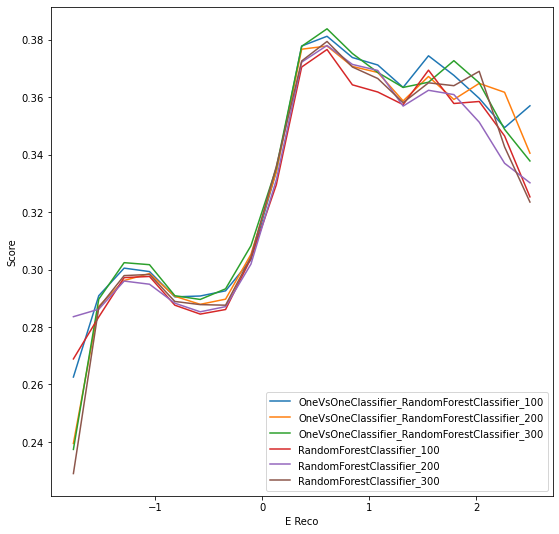

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 9])
log_e_reco_bins = np.linspace(-2., 2.5, 20)
for key in result_scores.keys():
    ax.plot(log_e_reco_bins[1:], result_scores[key], label=key)

plt.ylabel('Score')
plt.xlabel('E Reco')
plt.legend()
plt.show()


In [13]:
result_scores.keys()

dict_keys(['RandomForestClassifier_50', 'OneVsRestClassifier_RandomForestClassifier_50', 'OneVsOneClassifier_RandomForestClassifier_50'])

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[14, 14])
# Plot
log_e_reco_bins = np.linspace(-2., 2.5, 20)
rf_scores = []
for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue

    mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                          dtf['log_reco_energy'] < log_e_high)
    this_dtf = dtf[mask]
    if not len(this_dtf) > 0:
        continue
        
    print(np.floor((i-1)/4)%5, (i-1)%4)
    ax = axs[int(np.floor((i-1)/4)%5), (i-1)%4]
    
    dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

    X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
               'img2_ang', 'log_SizeSecondMax']
    X_train = dtf_train[X_names].values
    y_train = dtf_train[train_feature].values
    X_test = dtf_test[X_names].values
    y_test = dtf_test[train_feature].values

    # dividing X, y into train and test data 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

    # training a DescisionTreeClassifier 
    dtree_model = OneVsOneClassifier(RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=0, 
                                                             n_jobs=4)).fit(X_train, y_train) 
    dtree_predictions = dtree_model.predict(X_test) 
    score = round(dtree_model.score(X_test, y_test), 4)
    print("{:3.3f} < E < {:3.3f} -- Score: {}".format(10**log_e_reco_bins[i-1],
                                                      10**log_e_high,
                                                      score))
    rf_scores.append(score)
    
    # creating a confusion matrix 
    cm = confusion_matrix(y_test, dtree_predictions) 
    sns.heatmap(cm, annot=True, fmt='d', ax=ax,
                xticklabels=["{}".format(a) for a in np.arange(0,4,1)], 
                yticklabels=["{}".format(a) for a in np.arange(0,4,1)])
plt.show()
result_scores['OneVsOneClassifier_RandomForestClassifier_50'] = rf_scores.copy()

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[14, 14])
# Plot
log_e_reco_bins = np.linspace(-2., 2.5, 20)

for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue

    mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                          dtf['log_reco_energy'] < log_e_high)
    this_dtf = dtf[mask]
    if not len(this_dtf) > 0:
        continue
        
    print(np.floor((i-1)/4)%5, (i-1)%4)
    ax = axs[int(np.floor((i-1)/4)%5), (i-1)%4]
    
    dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

    X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
               'img2_ang', 'log_SizeSecondMax']
    X_train = dtf_train[X_names].values
    y_train = dtf_train[train_feature].values
    X_test = dtf_test[X_names].values
    y_test = dtf_test[train_feature].values

    # dividing X, y into train and test data 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

    # training a DescisionTreeClassifier 
#     svc=SVC(probability=True, kernel='linear')
    n_estimators=1
#     svc=BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), 
#                           max_samples=1.0 / n_estimators, n_estimators=n_estimators)
#     dtree_model = AdaBoostClassifier(n_estimators=50, base_estimator=svc,
#                                      learning_rate=1).fit(X_train, y_train) 
    print(len(this_dtf))
    if len(this_dtf) > 1000:
        n_estimators=round(len(this_dtf)/700)
        
    dtree_model = BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), 
                                    max_samples=1.0 / n_estimators, 
                                    n_estimators=n_estimators).fit(X_train, y_train) 
#     dtree_model = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True,
#                                                             class_weight='balanced'), 
#                                                         max_samples=1.0 / n_estimators, 
#                                                         n_estimators=n_estimators)).fit(X_train, y_train) 
#     dtree_model = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=0, 
#                                          n_jobs=4).fit(X_train, y_train) 
    
    dtree_predictions = dtree_model.predict(X_test) 

    print("{:3.3f} < E < {:3.3f} -- Score: {}".format(10**log_e_reco_bins[i-1],
                                                      10**log_e_high,
                                                      round(dtree_model.score(X_test, y_test), 4)))
    
    # creating a confusion matrix 
    cm = confusion_matrix(y_test, dtree_predictions) 
    sns.heatmap(cm, annot=True, fmt='d', ax=ax,
                xticklabels=["{}".format(a) for a in np.arange(0,4,1)], 
                yticklabels=["{}".format(a) for a in np.arange(0,4,1)])
plt.show()

0.0 0
560
0.010 < E < 0.017 -- Score: 0.2164
0.0 1
58445
0.017 < E < 0.030 -- Score: 0.2908
0.0 2
127770
0.030 < E < 0.051 -- Score: 0.2937
0.0 3
157743
0.051 < E < 0.089 -- Score: 0.2891
1.0 0
237813
0.089 < E < 0.153 -- Score: 0.2905
1.0 1
212106
0.153 < E < 0.264 -- Score: 0.3002
1.0 2
189246
0.264 < E < 0.455 -- Score: 0.3115
1.0 3
172768
0.455 < E < 0.785 -- Score: 0.3245
2.0 0
149592
0.785 < E < 1.354 -- Score: 0.3567
2.0 1
149278
1.354 < E < 2.336 -- Score: 0.4038
2.0 2
137447
2.336 < E < 4.030 -- Score: 0.4074
2.0 3
103278


0.0 0
560
0.010 < E < 0.017 -- Score: 0.2479
0.0 1
58445
0.017 < E < 0.030 -- Score: 0.2866
0.0 2
127770
0.030 < E < 0.051 -- Score: 0.2838
0.0 3
157743
0.051 < E < 0.089 -- Score: 0.2896
1.0 0
237813
0.089 < E < 0.153 -- Score: 0.2739
1.0 1
212106
0.153 < E < 0.264 -- Score: 0.2989
1.0 2
189246
0.264 < E < 0.455 -- Score: 0.3084
1.0 3
172768
0.455 < E < 0.785 -- Score: 0.3242
2.0 0
149592
0.785 < E < 1.354 -- Score: 0.3583
2.0 1
149278
1.354 < E < 2.336 -- Score: 0.4012
2.0 2
137447
2.336 < E < 4.030 -- Score: 0.4097
2.0 3
103278
4.030 < E < 6.952 -- Score: 0.3971
3.0 0
68364
6.952 < E < 11.994 -- Score: 0.3919
3.0 1
43076
11.994 < E < 20.691 -- Score: 0.3766
3.0 2
26442
20.691 < E < 35.697 -- Score: 0.3735
3.0 3
15866
35.697 < E < 61.585 -- Score: 0.3751
4.0 0
9286
61.585 < E < 106.247 -- Score: 0.3645
4.0 1
5619
106.247 < E < 183.298 -- Score: 0.3467
4.0 2
2640
183.298 < E < 316.228 -- Score: 0.3293


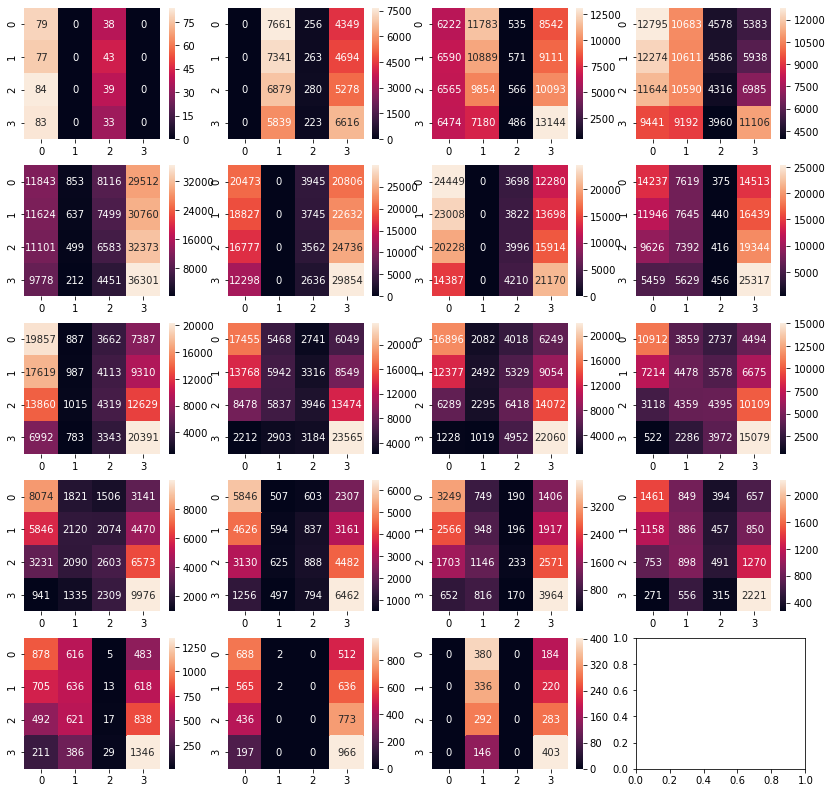

In [5]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[14, 14])
# Plot
log_e_reco_bins = np.linspace(-2., 2.5, 20)

for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue

    mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                          dtf['log_reco_energy'] < log_e_high)
    this_dtf = dtf[mask]
    if not len(this_dtf) > 0:
        continue
        
    print(np.floor((i-1)/4)%5, (i-1)%4)
    ax = axs[int(np.floor((i-1)/4)%5), (i-1)%4]
    
    dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

    X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
               'img2_ang', 'log_SizeSecondMax']
    X_train = dtf_train[X_names].values
    y_train = dtf_train[train_feature].values
    X_test = dtf_test[X_names].values
    y_test = dtf_test[train_feature].values

    # dividing X, y into train and test data 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

    # training a DescisionTreeClassifier 
#     svc=SVC(probability=True, kernel='linear')
    n_estimators=1
#     svc=BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), 
#                           max_samples=1.0 / n_estimators, n_estimators=n_estimators)
#     dtree_model = AdaBoostClassifier(n_estimators=50, base_estimator=svc,
#                                      learning_rate=1).fit(X_train, y_train) 
    print(len(this_dtf))
    if len(this_dtf) > 1000:
        n_estimators=round(len(this_dtf)/750)
        
    dtree_model = BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), 
                                    max_samples=1.0 / n_estimators, 
                                    n_estimators=n_estimators).fit(X_train, y_train) 
#     dtree_model = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True,
#                                                             class_weight='balanced'), 
#                                                         max_samples=1.0 / n_estimators, 
#                                                         n_estimators=n_estimators)).fit(X_train, y_train) 
#     dtree_model = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=0, 
#                                          n_jobs=4).fit(X_train, y_train) 
    
    dtree_predictions = dtree_model.predict(X_test) 

    print("{:3.3f} < E < {:3.3f} -- Score: {}".format(10**log_e_reco_bins[i-1],
                                                      10**log_e_high,
                                                      round(dtree_model.score(X_test, y_test), 4)))
    
    # creating a confusion matrix 
    cm = confusion_matrix(y_test, dtree_predictions) 
    sns.heatmap(cm, annot=True, fmt='d', ax=ax,
                xticklabels=["{}".format(a) for a in np.arange(0,4,1)], 
                yticklabels=["{}".format(a) for a in np.arange(0,4,1)])
plt.show()

0.0 0
560
0.010 < E < 0.017 -- Score: 0.2815
0.0 1
58445
0.017 < E < 0.030 -- Score: 0.2981
0.0 2
127770
0.030 < E < 0.051 -- Score: 0.3045
0.0 3
157743
0.051 < E < 0.089 -- Score: 0.2998
1.0 0
237813
0.089 < E < 0.153 -- Score: 0.2936
1.0 1
212106
0.153 < E < 0.264 -- Score: 0.3037
1.0 2
189246
0.264 < E < 0.455 -- Score: 0.3114
1.0 3
172768
0.455 < E < 0.785 -- Score: 0.3241
2.0 0
149592
0.785 < E < 1.354 -- Score: 0.359
2.0 1
149278
1.354 < E < 2.336 -- Score: 0.4033
2.0 2
137447
2.336 < E < 4.030 -- Score: 0.4074
2.0 3
103278
4.030 < E < 6.952 -- Score: 0.3948
3.0 0
68364
6.952 < E < 11.994 -- Score: 0.3902
3.0 1
43076
11.994 < E < 20.691 -- Score: 0.3812
3.0 2
26442
20.691 < E < 35.697 -- Score: 0.3807
3.0 3
15866
35.697 < E < 61.585 -- Score: 0.3754
4.0 0
9286
61.585 < E < 106.247 -- Score: 0.3696
4.0 1
5619
106.247 < E < 183.298 -- Score: 0.323
4.0 2
2640
183.298 < E < 316.228 -- Score: 0.34


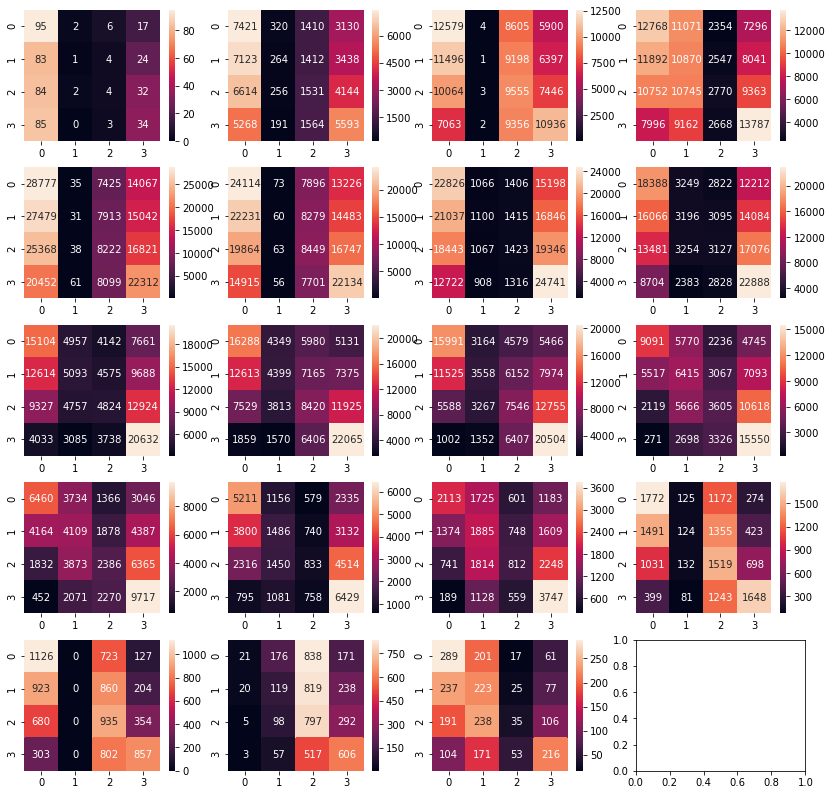

In [8]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[14, 14])
# Plot
log_e_reco_bins = np.linspace(-2., 2.5, 20)

for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue

    mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                          dtf['log_reco_energy'] < log_e_high)
    this_dtf = dtf[mask]
    if not len(this_dtf) > 0:
        continue
        
    print(np.floor((i-1)/4)%5, (i-1)%4)
    ax = axs[int(np.floor((i-1)/4)%5), (i-1)%4]
    
    dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

    X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
               'img2_ang', 'log_SizeSecondMax']
    X_train = dtf_train[X_names].values
    y_train = dtf_train[train_feature].values
    X_test = dtf_test[X_names].values
    y_test = dtf_test[train_feature].values

    # dividing X, y into train and test data 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

    # training a DescisionTreeClassifier 
#     svc=SVC(probability=True, kernel='linear')
    n_estimators=1
#     svc=BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), 
#                           max_samples=1.0 / n_estimators, n_estimators=n_estimators)
#     dtree_model = AdaBoostClassifier(n_estimators=50, base_estimator=svc,
#                                      learning_rate=1).fit(X_train, y_train) 
    print(len(this_dtf))
    if len(this_dtf) > 1000:
        n_estimators=round(len(this_dtf)/750)
        
#     dtree_model = BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), 
#                                     max_samples=1.0 / n_estimators, 
#                                     n_estimators=n_estimators).fit(X_train, y_train) 
    dtree_model = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True,
                                                            class_weight='balanced'), 
                                                        max_samples=1.0 / n_estimators, 
                                                        n_estimators=n_estimators)).fit(X_train, y_train) 
#     dtree_model = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=0, 
#                                          n_jobs=4).fit(X_train, y_train) 
    
    dtree_predictions = dtree_model.predict(X_test) 

    print("{:3.3f} < E < {:3.3f} -- Score: {}".format(10**log_e_reco_bins[i-1],
                                                      10**log_e_high,
                                                      round(dtree_model.score(X_test, y_test), 4)))
    
    # creating a confusion matrix 
    cm = confusion_matrix(y_test, dtree_predictions) 
    sns.heatmap(cm, annot=True, fmt='d', ax=ax,
                xticklabels=["{}".format(a) for a in np.arange(0,4,1)], 
                yticklabels=["{}".format(a) for a in np.arange(0,4,1)])
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[14, 14])
# Plot
log_e_reco_bins = np.linspace(-2., 2.5, 20)

for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue

    mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                          dtf['log_reco_energy'] < log_e_high)
    this_dtf = dtf[mask]
    if not len(this_dtf) > 0:
        continue
        
    print(np.floor((i-1)/4)%5, (i-1)%4)
    ax = axs[int(np.floor((i-1)/4)%5), (i-1)%4]
    
    dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

    X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
               'img2_ang', 'log_SizeSecondMax']
    X_train = dtf_train[X_names].values
    y_train = dtf_train[train_feature].values
    X_test = dtf_test[X_names].values
    y_test = dtf_test[train_feature].values

    # dividing X, y into train and test data 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

    # training a DescisionTreeClassifier 
#     svc=SVC(probability=True, kernel='linear')
    n_estimators=1
#     svc=BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), 
#                           max_samples=1.0 / n_estimators, n_estimators=n_estimators)
#     dtree_model = AdaBoostClassifier(n_estimators=50, base_estimator=svc,
#                                      learning_rate=1).fit(X_train, y_train) 
    print(len(this_dtf))
    if len(this_dtf) > 1000:
        n_estimators=round(len(this_dtf)/750)
        
#     dtree_model = BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), 
#                                     max_samples=1.0 / n_estimators, 
#                                     n_estimators=n_estimators).fit(X_train, y_train) 
    dtree_model = OneVsOneClassifier(BaggingClassifier(SVC(kernel='linear', probability=True,
                                                            class_weight='balanced'), 
                                                        max_samples=1.0 / n_estimators, 
                                                        n_estimators=n_estimators)).fit(X_train, y_train) 
#     dtree_model = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=0, 
#                                          n_jobs=4).fit(X_train, y_train) 
    
    dtree_predictions = dtree_model.predict(X_test) 

    print("{:3.3f} < E < {:3.3f} -- Score: {}".format(10**log_e_reco_bins[i-1],
                                                      10**log_e_high,
                                                      round(dtree_model.score(X_test, y_test), 4)))
    
    # creating a confusion matrix 
    cm = confusion_matrix(y_test, dtree_predictions) 
    sns.heatmap(cm, annot=True, fmt='d', ax=ax,
                xticklabels=["{}".format(a) for a in np.arange(0,4,1)], 
                yticklabels=["{}".format(a) for a in np.arange(0,4,1)])
plt.show()

0.0 0
560
0.010 < E < 0.017 -- Score: 0.2416
0.0 1
58445
0.017 < E < 0.030 -- Score: 0.2867
0.0 2
127770
0.030 < E < 0.051 -- Score: 0.2889
0.0 3
157743
0.051 < E < 0.089 -- Score: 0.2895
1.0 0
237813
0.089 < E < 0.153 -- Score: 0.2803
1.0 1
212106
0.153 < E < 0.264 -- Score: 0.3017
1.0 2
189246
0.264 < E < 0.455 -- Score: 0.3001
1.0 3
172768
0.455 < E < 0.785 -- Score: 0.3124
2.0 0
149592
0.785 < E < 1.354 -- Score: 0.3369
2.0 1
149278
1.354 < E < 2.336 -- Score: 0.4019
2.0 2
137447
2.336 < E < 4.030 -- Score: 0.4055
2.0 3
103278
4.030 < E < 6.952 -- Score: 0.3897
3.0 0
68364


In [12]:
print(round(LR.score(X_test,y_test), 4))
print(round(SVM.score(X_test, y_test), 4))
print(round(RF.score(X_test, y_test), 4))
print(round(NN.score(X_test, y_test), 4))

0.2777
0.2544
0.3085
0.2494


In [ ]:
# compare algorithms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# Load dataset
X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 'img2_ang', 'log_SizeSecondMax']
X_train = dtf_train[X_names].values
y_train = dtf_train[train_feature].values
X_test = dtf_test[X_names].values
y_test = dtf_test[train_feature].values

X_train = X_train
X_validation = X_test
Y_train = y_train
Y_validation = y_test
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators = 100, 
                                              criterion = 'entropy', random_state = 42)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel='linear')))
# models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


LR: 0.295532 (0.004620)


/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


LDA: 0.296483 (0.003537)


/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


KNN: 0.261511 (0.005545)


/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


CART: 0.270289 (0.004257)
NB: 0.270973 (0.005884)


/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Explore BDTs:

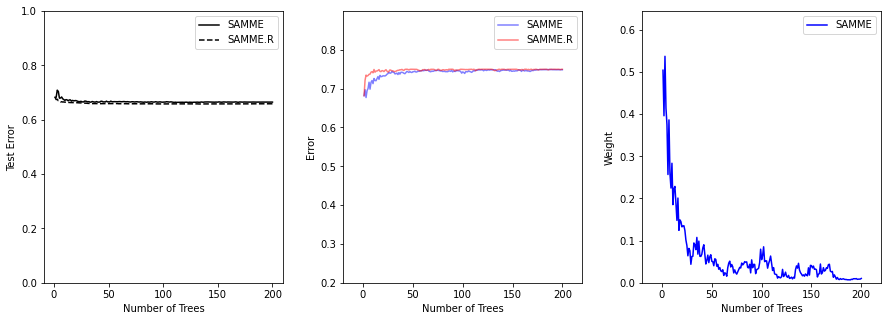

In [66]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.85)## print info

train_feature = "event_types"
X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 'img2_ang', 'log_SizeSecondMax']
X_train = dtf_train[X_names].values
y_train = dtf_train[train_feature].values
X_test = dtf_test[X_names].values
y_test = dtf_test[train_feature].values


bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=200,
    learning_rate=1)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=200,
    learning_rate=1.5,
    algorithm="SAMME")

bdt_real.fit(X_train, y_train)
bdt_discrete.fit(X_train, y_train)

real_test_errors = []
discrete_test_errors = []

for real_test_predict, discrete_train_predict in zip(
        bdt_real.staged_predict(X_test), bdt_discrete.staged_predict(X_test)):
    real_test_errors.append(
        1. - accuracy_score(real_test_predict, y_test))
    discrete_test_errors.append(
        1. - accuracy_score(discrete_train_predict, y_test))

n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)

# Boosting might terminate early, but the following arrays are always
# n_estimators long. We crop them to the actual number of trees here:
discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(1, n_trees_discrete + 1),
         discrete_test_errors, c='black', label='SAMME')
plt.plot(range(1, n_trees_real + 1),
         real_test_errors, c='black',
         linestyle='dashed', label='SAMME.R')
plt.legend()
plt.ylim(0., 1.0)
plt.ylabel('Test Error')
plt.xlabel('Number of Trees')

plt.subplot(132)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_errors,
         "b", label='SAMME', alpha=.5)
plt.plot(range(1, n_trees_real + 1), real_estimator_errors,
         "r", label='SAMME.R', alpha=.5)
plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.ylim((.2,
         max(real_estimator_errors.max(),
             discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(133)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights,
         "b", label='SAMME')
plt.legend()
plt.ylabel('Weight')
plt.xlabel('Number of Trees')
plt.ylim((0, discrete_estimator_weights.max() * 1.2))
plt.xlim((-20, n_trees_discrete + 20))

# prevent overlapping y-axis labels
plt.subplots_adjust(wspace=0.25)
plt.show()


In [19]:
# gamma_file = uproot.open("gamma_cone.S.3HB9-FD_ID0.eff-0.root")
gamma_file = uproot.open("gamma_onSource.S.3HB9-FD_ID0.eff-0.root")
# proton_file = uproot.open("proton_onSource.S.3HB9-FD_ID0.eff-0.root")

In [20]:
gamma_file.keys()

[b'fEffArea;1',
 b'hEmc;2',
 b'hEmc;1',
 b'fEventTreeCuts;1',
 b'data;1',
 b't_angular_resolution;1',
 b't_angular_resolution_080p;1',
 b't_angular_resolution_095p;1',
 b't_core_resolution;1',
 b't_energy_resolution;1',
 b'GammaHadronCutsStats;1',
 b'TMVAEvaluatorResults;1',
 b'GammaHadronCuts;1',
 b'MC_runheader;1',
 b'makeEffectiveArea_runparameter;1']

In [21]:
data = gamma_file["data"]

In [23]:
data.keys()

[b'runNumber',
 b'eventNumber',
 b'MJD',
 b'Time',
 b'TelElevation',
 b'TelAzimuth',
 b'ArrayPointing_Elevation',
 b'ArrayPointing_Azimuth',
 b'WobbleN',
 b'WobbleE',
 b'LTrig',
 b'NTrig',
 b'NImages',
 b'ImgSel',
 b'MCprimary',
 b'MCe0',
 b'MCxcore',
 b'MCycore',
 b'MCaz',
 b'MCze',
 b'MCxoff',
 b'MCyoff',
 b'MCCorsikaRunID',
 b'MCCorsikaShowerID',
 b'MCFirstInteractionHeight',
 b'MCFirstInteractionDepth',
 b'MCR',
 b'ImgSel_list',
 b'NTtype',
 b'TtypeID',
 b'NImages_Ttype',
 b'img2_ang',
 b'RecID',
 b'Ze',
 b'Az',
 b'Xoff',
 b'Yoff',
 b'Xoff_derot',
 b'Yoff_derot',
 b'stdS',
 b'Xcore',
 b'Ycore',
 b'stdP',
 b'Chi2',
 b'meanPedvar_Image',
 b'ntubes',
 b'dist',
 b'fui',
 b'size',
 b'loss',
 b'width',
 b'length',
 b'tgrad_x',
 b'DispNImages',
 b'DispXoff_T',
 b'DispYoff_T',
 b'DispWoff_T',
 b'DispDiff',
 b'Xoff_intersect',
 b'Yoff_intersect',
 b'cross',
 b'crossO',
 b'R',
 b'NMSCW',
 b'ES',
 b'MSCW',
 b'MSCL',
 b'MWR',
 b'MLR',
 b'ErecS',
 b'EChi2S',
 b'dES',
 b'dESabs',
 b'NErecST',
 b

In [56]:
cross = data.array('dES')[gamma_like_events]
cross

array([0.15750434, 0.07138596, 0.07593285, ..., 0.16507931, 0.19460683,
       0.12524788])

In [57]:
crossO = data.array('dESabs')[gamma_like_events]
crossO

array([0.00577715, 0.63479972, 0.65982693, ..., 0.28019682, 0.71403992,
       0.01918565])

In [24]:
cuts = gamma_file["fEventTreeCuts"]

# Cut 1: Events surviving gamma/hadron separation and direction cuts:
mask_gamma_like_and_direction = cuts.array('CutClass') == 5

# Cut 2: Events surviving gamma/hadron separation cut and not direction cut:
mask_gamma_like_no_direction = cuts.array('CutClass') == 0

gamma_like_events = np.logical_or(mask_gamma_like_and_direction, mask_gamma_like_no_direction)

In [25]:
# Definition of TtypeID within eventDisplay:
all_ttypes = {138704810: 'LST',
              10408618: 'MST-FlashCam',
              10408418: 'MST-NectarCam',
              201511619: 'SST-ASTRI',
              201309316: 'SST-GC',
              909924: 'SST-DC',
              207308707: 'MST-SC'}
# Identify the telescope types within the 'NImages_Ttype' array:
tel_types = [all_ttypes[t] for t in data.array("TtypeID")[0]]
print('File containing the following telescope types: {}'.format(tel_types))
for i, tel in enumerate(tel_types):
    # TODO: Note if some MSTs are of one type and some other MSTs of another, this will not work.
    # TODO: The solution is perhaps to store as NTels_reco[all_telescope_types], or more simply
    # TODO: a dictionary.
    if 'LST' in tel:
        NTels_reco_lst = [images_type[i] for images_type in data.array("NImages_Ttype")[gamma_like_events]]
    if 'MST' in tel:
        NTels_reco_mst = [images_type[i] for images_type in data.array("NImages_Ttype")[gamma_like_events]]
    if 'SST' in tel:
        NTels_reco_sst = [images_type[i] for images_type in data.array("NImages_Ttype")[gamma_like_events]]


File containing the following telescope types: ['SST-DC', 'MST-FlashCam', 'LST']


In [59]:
mc_energy = data.array("MCe0")[gamma_like_events]  # mc_energy = tb.Float32Col(dflt=np.nan, pos=7)

# Variables for regression:
mc_alt = 90 - data.array("MCze")[gamma_like_events]
mc_az = data.array("MCaz")[gamma_like_events]
reco_alt = 90 - data.array("Ze")[gamma_like_events]  # reco_alt = tb.Float32Col(dflt=np.nan, pos=9)
reco_az = data.array("Az")[gamma_like_events]  # reco_az = tb.Float32Col(dflt=np.nan, pos=10)
# Angular separation bewteen the true vs reconstructed direction
ang_diff = angular_separation(
    mc_az * u.deg,  # az
    mc_alt * u.deg,  # alt
    reco_az * u.deg,
    reco_alt * u.deg,
)


# Variables for training:
av_size = [np.average(sizes) for sizes in data.array("size")[gamma_like_events]]       
reco_energy = data.array("ErecS")[gamma_like_events]  
NTels_reco = data.array("NImages")[gamma_like_events]
x_cores = data.array('Xcore')[gamma_like_events]
y_cores = data.array('Ycore')[gamma_like_events]
array_distance = np.sqrt(x_cores**2. + y_cores**2.)
x_off = data.array('Xoff')[gamma_like_events]
y_off = data.array('Yoff')[gamma_like_events]
camera_offset = np.sqrt(x_off**2. + y_off**2.)
img2_ang = data.array('img2_ang')[gamma_like_events]
EChi2S = data.array('EChi2S')[gamma_like_events]
SizeSecondMax = data.array('SizeSecondMax')[gamma_like_events]
NTelPairs = data.array('NTelPairs')[gamma_like_events]
MSCW = data.array('MSCW')[gamma_like_events]
MSCL = data.array('MSCL')[gamma_like_events]
EmissionHeight = data.array('EmissionHeight')[gamma_like_events]
EmissionHeightChi2 = data.array('EmissionHeightChi2')[gamma_like_events]
dist = data.array('dist')[gamma_like_events]
av_dist = [np.average(dists) for dists in dist]     
DispDiff = data.array('DispDiff')[gamma_like_events]
dESabs = data.array('dESabs')[gamma_like_events]


In [60]:
# Bin in reconstructed energy, and calculate percentiles (in this case 4 event types):
event_types = np.zeros_like(reco_energy)
log_e_reco_bins = np.linspace(-2., 2.5, 40)
for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue
    e_low = 10**log_e_reco_bins[i-1]
    e_high = 10**log_e_high
    # Select events within the rec. energy bin:
    events = np.logical_and(reco_energy > e_low, reco_energy < e_high)
    # Make sure there are events:
    if not np.sum(events) > 0:
        continue
    p1 = np.percentile(ang_diff[events], 25)
    p2 = np.percentile(ang_diff[events], 50)
    p3 = np.percentile(ang_diff[events], 75)
    event_types[np.logical_and(events, ang_diff < p1)] = 1
    event_types[np.logical_and(np.logical_and(events, ang_diff >= p1), ang_diff < p2)] = 2
    event_types[np.logical_and(np.logical_and(events, ang_diff >= p2), ang_diff < p3)] = 3
    event_types[np.logical_and(events, ang_diff >= p3)] = 4

In [64]:
# Build astropy table:
t = Table()
t['log_ang_diff'] = np.log10(ang_diff.value)
# t['log_av_size'] = np.log10(av_size)
t['log_reco_energy'] = np.log10(reco_energy)
t['log_NTels_reco'] = np.log10(NTels_reco)
t['array_distance'] = array_distance
t['img2_ang'] = img2_ang
# t['log_EChi2S'] = np.log10(EChi2S)
t['log_SizeSecondMax'] = np.log10(SizeSecondMax)
# t['log_NTelPairs'] = np.log10(NTelPairs)
# t['MSCW'] = MSCW
# t['MSCL'] = MSCL
# t['camera_offset'] = camera_offset
t['log_EmissionHeight'] = np.log10(EmissionHeight)
t['log_EmissionHeightChi2'] = np.log10(EmissionHeightChi2)
t['event_types'] = event_types
t['av_dist'] = av_dist
t['log_DispDiff'] = np.log10(DispDiff)
t['log_EChi2S'] = np.log10(EChi2S)
t['log_dESabs'] = np.log10(dESabs)
t['log_EmissionHeight'] = np.log10(EmissionHeight)
t['log_EmissionHeightChi2'] = np.log10(EmissionHeightChi2)

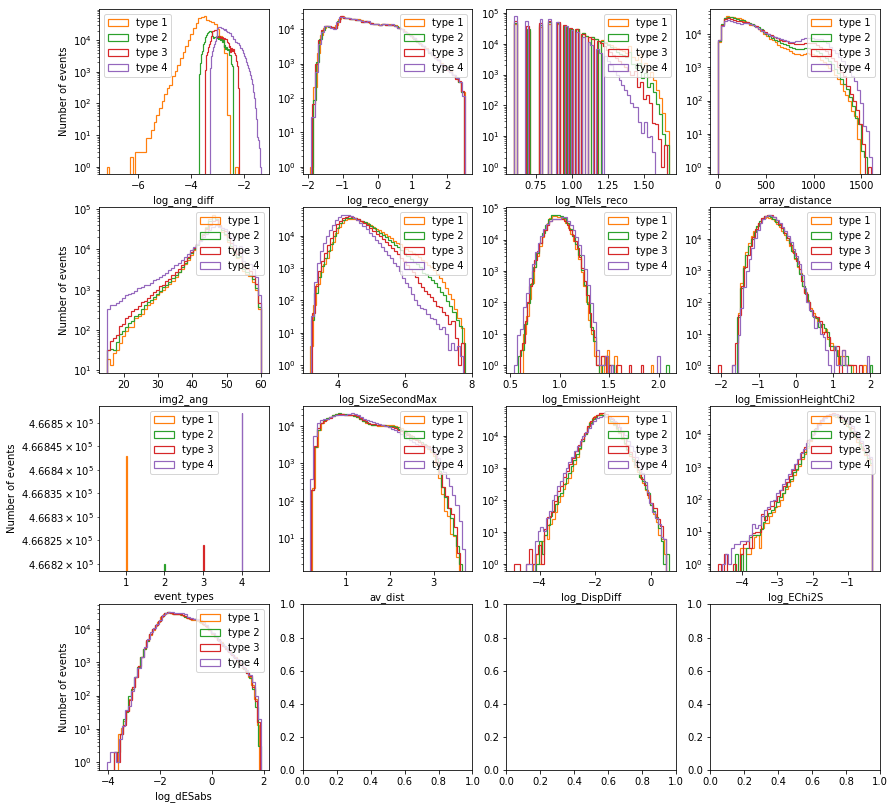

In [65]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=[14, 14])
# Plot
for i, colname in enumerate(t.colnames):
    ax = axs[int(np.floor(i/4)%4), i%4]
    for event_type in [1,2,3,4]:
        mask = t['event_types']==event_type
        this_table = t[mask]
        n, bins, patches = ax.hist(this_table[colname], 50, histtype='step', density=False, alpha=1.0, 
                                   edgecolor="C{}".format(event_type), linewidth=1.2, 
                                   label="type {}".format(event_type))
    ax.legend()
    ax.set_xlabel(colname)
    if i%4 is 0:
        ax.set_ylabel('Number of events')
#     ax.set_xscale('log')
    ax.set_yscale('log')
plt.show()

In [26]:
dtf = t.to_pandas()

In [27]:
'''
Recognize whether a column is numerical or categorical.
'''
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

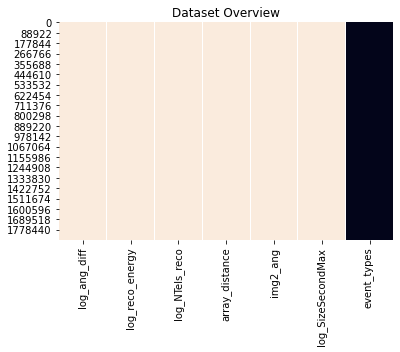

 Categerocial   Numeric   NaN 


In [29]:
max_cat=20
dic_cols = {col:utils_recognize_type(dtf, col, max_cat=max_cat) for col in dtf.columns}
heatmap = dtf.isnull()
for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)

sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [ ]:
# compare algorithms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# Load dataset
dataset = t.to_pandas()
# Split-out validation dataset
array = dataset.values
# We remove the ang_diff, and leave the event type as Y:
X = array[:,1:6]
y = array[:,6]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.60, random_state=1, 
                                                                shuffle=True)
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


LR: 0.331806 (0.000733)


/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


LDA: 0.332654 (0.001151)


/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


KNN: 0.291510 (0.001480)


/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


CART: 0.285828 (0.001951)


/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


NB: 0.331059 (0.001328)


/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, 
                                                                                 df.index, test_size=0.33, 
                                                                                 random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
## for machine learning



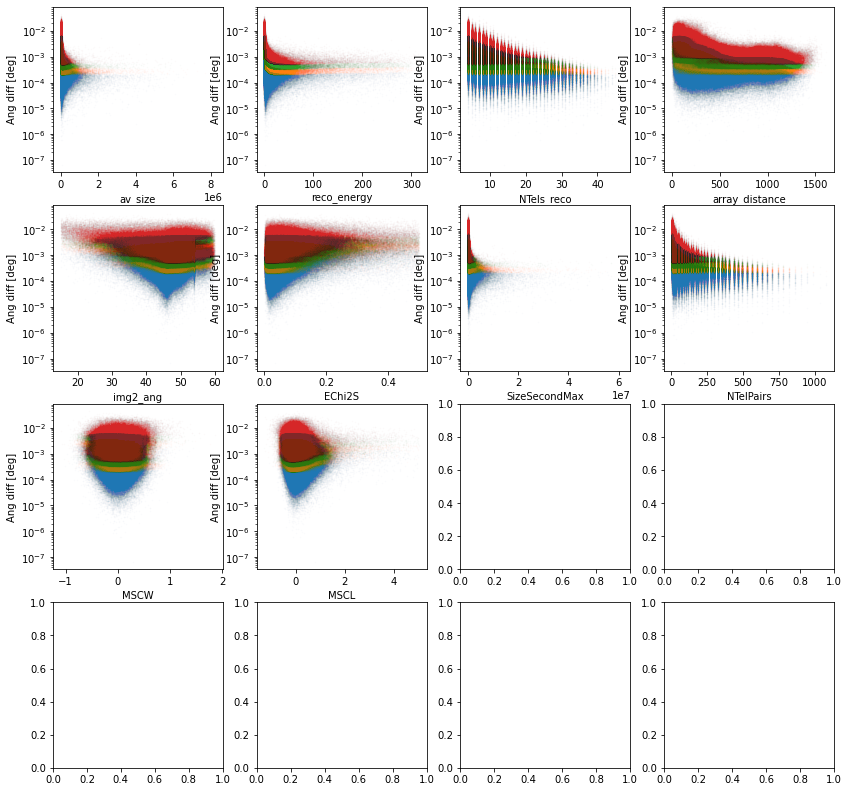

In [145]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=[14, 14])
# Plot
for i, colname in enumerate(t.colnames[1:-1]):
    ax = axs[int(np.floor(i/4)%4), i%4]
    for event_type in [1,2,3,4]:
        mask = t['event_types']==event_type
        this_table = t[mask]
        ax.scatter(this_table[colname], this_table['ang_diff'], alpha=0.01, 
                    s=1, label="type {}".format(event_type))
#     ax.legend()
    ax.set_xlabel(colname)
    ax.set_ylabel('Ang diff [deg]')
#     ax.set_xscale('log')
    ax.set_yscale('log')
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=[14, 7])
# Plot
for event_type in [1,2,3,4]:
    mask = t['event_types']==event_type
    this_table = t[mask]
    axs.scatter(this_table['reco_energy'], this_table['ang_diff'], alpha=0.1, 
                s=1, label="type {}".format(event_type))
axs.set_xlabel('Rec Energy')
axs.set_ylabel('Ang diff [deg]')
axs.set_xscale('log')
axs.set_yscale('log')
plt.show()

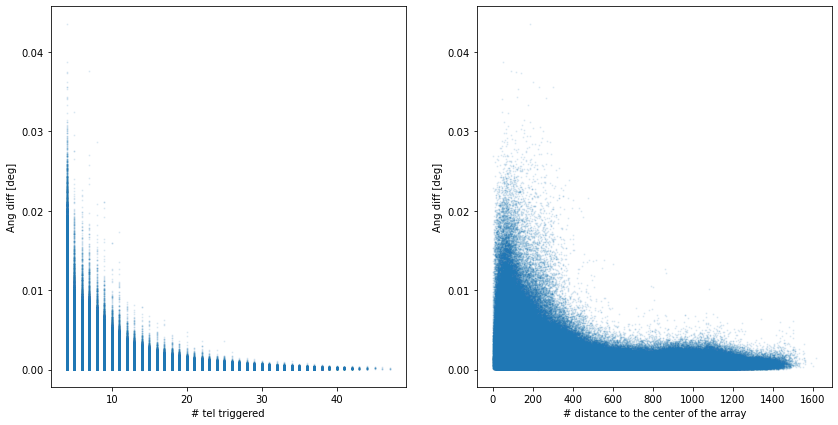

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[14, 7])

# Plot
for t in [1,2,3,4]:
    
    axs[0].scatter(NTels_reco, ang_diff, alpha=0.1, s=1)
    axs[0].set_xlabel('# tel triggered')
    axs[0].set_ylabel('Ang diff [deg]')

    axs[1].scatter(array_distance, ang_diff, alpha=0.1, s=1)
    axs[1].set_xlabel('# distance to the center of the array')
    axs[1].set_ylabel('Ang diff [deg]')
#     ax.title('X/Y cores')
#     ax.xlabel('x')
#     ax.ylabel('y')
plt.show()

In [4]:
mc_energy_hist = gamma_file['hEmc;1']

In [5]:
bin_content, bin_edges = mc_energy_hist.numpy()

In [6]:
bin_content

array([2.11031867e+10, 1.49394752e+10, 1.05759676e+10, 7.48743384e+09,
       5.30155606e+09, 3.75365415e+09, 2.65683326e+09, 1.88066457e+09,
       1.33185122e+09, 9.41965251e+08, 6.66276741e+08, 4.71858251e+08,
       3.34548871e+08, 2.36298561e+08, 1.67836516e+08, 1.18509122e+08,
       8.39464579e+07, 5.94984041e+07, 4.21071190e+07, 2.97400456e+07,
       2.10623637e+07, 1.49444227e+07, 1.06564244e+07, 7.48342503e+06,
       5.25758440e+06, 3.73173060e+06, 2.65654994e+06, 1.88628108e+06,
       1.33210701e+06, 9.47258567e+05, 6.71102389e+05, 4.71099852e+05,
       3.34479902e+05, 2.36881796e+05, 1.67564369e+05, 1.14381887e+05,
       8.16580160e+04, 6.04423794e+04, 4.09352990e+04, 3.02078612e+04,
       2.10438660e+04, 1.51731999e+04, 9.71300108e+03, 7.27960184e+03,
       5.20806385e+03, 5.35697363e+02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [7]:
gamma_file['fEventTreeCuts']['CutClass']

<TBranch b'CutClass' at 0x7feb607f56d8>

In [8]:
cuts = gamma_file["fEventTreeCuts"]
data = gamma_file["data"]

In [9]:
cuts.show()

CutClass                   (no streamer)              asdtype('>i4')
MVA                        (no streamer)              asdtype('>f4')


In [10]:
# Events surviving gamma/hadron separation and direction cuts:
gamma_like_and_direction = cuts.array('CutClass') == 5

# Events surviving gamma/hadron separation cut:
gamma_like = cuts.array('CutClass') == 0

In [11]:
gamma_like_and_direction

array([ True, False, False, ..., False, False, False])

In [12]:
len(data.array("width"))

7217616

In [10]:
i = 10
print("Shower energy: {}".format(data.array("MCe0")[i]))
print("NImages type: {}".format(data.array("NImages_Ttype")[i]))
print("Number of triggered telescopes: {}".format(data.array("NTrig")[i]))
print("NImages selected: {}".format(data.array("NImages")[i]))
print("Dist to array center: {} m".format(np.sqrt(data.array("MCxcore")[i]**2+data.array("MCxcore")[i]**2)))

Shower energy: 8.710504531860352
NImages type: [6 3 0]
Number of triggered telescopes: 9
NImages selected: 9
Dist to array center: 1055.1951133393861 m


In [14]:
data

<TTree b'data' at 0x7feb607f5ac8>

In [15]:
data_mask = gamma_like
obs_id = data.array("runNumber")[data_mask]               #     obs_id = tb.Int16Col(dflt=-1, pos=0)
event_id = data.array("eventNumber")[data_mask]           #     event_id = tb.Int32Col(dflt=-1, pos=1)
NTels_trig = data.array("NTrig")[data_mask]               #     NTels_trig = tb.Int16Col(dflt=0, pos=2)
NTels_reco = data.array("NImages")[data_mask]             #     NTels_reco = tb.Int16Col(dflt=0, pos=3)
NTels_reco_lst = [images_type[2] for images_type in data.array("NImages_Ttype")[data_mask]]      
                                                          #(2)  NTels_reco_lst = tb.Int16Col(dflt=0, pos=4)
NTels_reco_mst = [images_type[1] for images_type in data.array("NImages_Ttype")[data_mask]]      
                                                          #(1)  NTels_reco_mst = tb.Int16Col(dflt=0, pos=5)
NTels_reco_sst = [images_type[0] for images_type in data.array("NImages_Ttype")[data_mask]]      
                                                          #(0)  NTels_reco_sst = tb.Int16Col(dflt=0, pos=6)
mc_energy = data.array("MCe0")[data_mask]                 #     mc_energy = tb.Float32Col(dflt=np.nan, pos=7)
reco_energy = data.array("ErecS")[data_mask]              #     reco_energy = tb.Float32Col(dflt=np.nan, pos=8)
mc_alt = 90 - data.array("MCze")[data_mask]
mc_az = data.array("MCaz")[data_mask]
reco_alt = 90 - data.array("Ze")[data_mask]               #     reco_alt = tb.Float32Col(dflt=np.nan, pos=9)
reco_az = data.array("Az")[data_mask]                     #     reco_az = tb.Float32Col(dflt=np.nan, pos=10)

pointing_elevation = data.array("ArrayPointing_Elevation")[data_mask]
pointing_azimuth = data.array("ArrayPointing_Azimuth")[data_mask]

# Angular separation bewteen the center of the camera and the reco direction.
offset = angular_separation(                   #     offset = tb.Float32Col(dflt=np.nan, pos=11)
    pointing_azimuth*u.deg,  # az
    pointing_elevation*u.deg,  # alt
    reco_az*u.deg,
    reco_alt*u.deg,
)

xi = angular_separation(
    mc_az*u.deg, mc_alt*u.deg, reco_az*u.deg, reco_alt*u.deg
)
# NTels_trig = data.array("NImages_Ttype")       #     ErrEstPos = tb.Float32Col(dflt=np.nan, pos=13)
# NTels_trig = data.array("NImages_Ttype")       #     ErrEstDir = tb.Float32Col(dflt=np.nan, pos=14)
# NTels_trig = data.array("NImages_Ttype")       #     gammaness = tb.Float32Col(dflt=np.nan, pos=15)
# NTels_trig = data.array("NImages_Ttype")       #     success = tb.BoolCol(dflt=False, pos=16)
# NTels_trig = data.array("NImages_Ttype")       #     score = tb.Float32Col(dflt=np.nan, pos=17)
h_max = data.array("EmissionHeight")[data_mask]        #     h_max = tb.Float32Col(dflt=np.nan, pos=18)
reco_core_x = data.array("Xcore")[data_mask]           #     reco_core_x = tb.Float32Col(dflt=np.nan, pos=19)
reco_core_y = data.array("Ycore")[data_mask]           #     reco_core_y = tb.Float32Col(dflt=np.nan, pos=20)
mc_core_x = data.array("MCxcore")[data_mask]           #     mc_core_x = tb.Float32Col(dflt=np.nan, pos=21)
mc_core_y = data.array("MCycore")[data_mask]           #     mc_core_y = tb.Float32Col(dflt=np.nan, pos=22)

In [16]:
data.show()

runNumber                  (no streamer)              asdtype('>i4')
eventNumber                (no streamer)              asdtype('>i4')
MJD                        (no streamer)              asdtype('>i4')
Time                       (no streamer)              asdtype('>f8')
TelElevation               (no streamer)              asdtype("('>f8', (99,))")
TelAzimuth                 (no streamer)              asdtype("('>f8', (99,))")
ArrayPointing_Elevation    (no streamer)              asdtype('>f4')
ArrayPointing_Azimuth      (no streamer)              asdtype('>f4')
WobbleN                    (no streamer)              asdtype('>f8')
WobbleE                    (no streamer)              asdtype('>f8')
LTrig                      (no streamer)              asdtype('>u8')
NTrig                      (no streamer)              asdtype('>u4')
NImages                    (no streamer)              asdtype('>i4')
ImgSel                     (no streamer)              asdtype('>u8')
MCprimary   

In [17]:
# i = 10
i = 20
for i in np.arange(0, 100, 1):
    print("Shower energy: {}".format(data.array("MCe0")[i]))
    print("NImages type: {}".format(data.array("NImages_Ttype")[i]))
    print("Number of triggered telescopes: {}".format(data.array("NTrig")[i]))
    print("NImages selected: {}".format(data.array("NImages")[i]))
    print("Dist to array center: {} m".format(np.sqrt(data.array("MCxcore")[i]**2+data.array("MCxcore")[i]**2)))
    print("ImgSel_list: ", data.array("ImgSel_list")[i])

Shower energy: 0.04423386603593826
NImages type: [0 0 4]
Number of triggered telescopes: 4
NImages selected: 4
Dist to array center: 103.86496174053563 m
ImgSel_list:  [0 1 2 3]
Shower energy: 0.14956964552402496
NImages type: [0 2 0]
Number of triggered telescopes: 2
NImages selected: 2
Dist to array center: 455.91849098046555 m
ImgSel_list:  [20 24]
Shower energy: 0.06703189760446548
NImages type: [0 0 4]
Number of triggered telescopes: 4
NImages selected: 4
Dist to array center: 236.2407546069413 m
ImgSel_list:  [0 1 2 3]
Shower energy: 0.03158556669950485
NImages type: [0 1 4]
Number of triggered telescopes: 5
NImages selected: 5
Dist to array center: 29.66145762330642 m
ImgSel_list:  [0 1 2 3 9]
Shower energy: 0.05893321707844734
NImages type: [0 0 2]
Number of triggered telescopes: 2
NImages selected: 2
Dist to array center: 62.82542760249947 m
ImgSel_list:  [0 2]
Shower energy: 8.710504531860352
NImages type: [4 0 0]
Number of triggered telescopes: 4
NImages selected: 4
Dist to 

KeyboardInterrupt: 

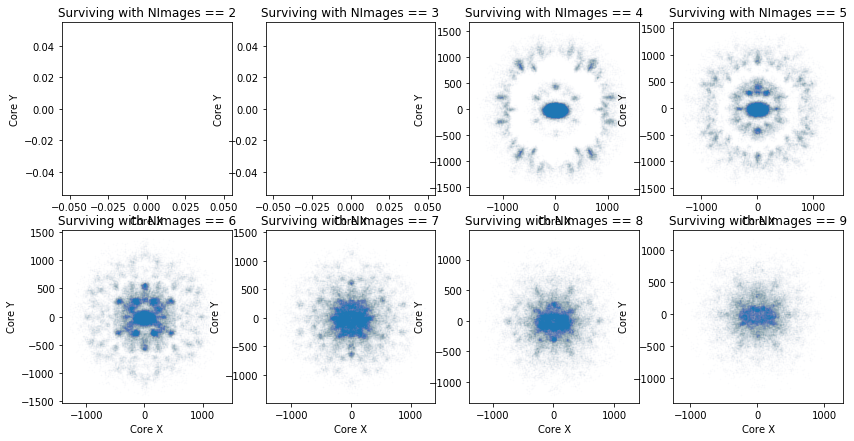

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=[14, 7])
for i, n_images in enumerate([2, 3, 4, 5, 6, 7, 8, 9]):
    ax = axs[int(np.floor(i/4)%4), i%4]
    # Multiplicity cut:
    multiplicity_cut = data.array('NImages') == n_images

    # Create data
    x_cores = data.array('Xcore')[np.logical_and(multiplicity_cut, gamma_like)]
    y_cores = data.array('Ycore')[np.logical_and(multiplicity_cut, gamma_like)]

    # Plot
    ax.scatter(x_cores, y_cores, alpha=0.01, s=1)
    ax.set_title("Surviving with NImages == {}".format(n_images))
    ax.set_xlabel('Core X')
    ax.set_ylabel('Core Y')
#     ax.title('X/Y cores')
#     ax.xlabel('x')
#     ax.ylabel('y')
plt.show()

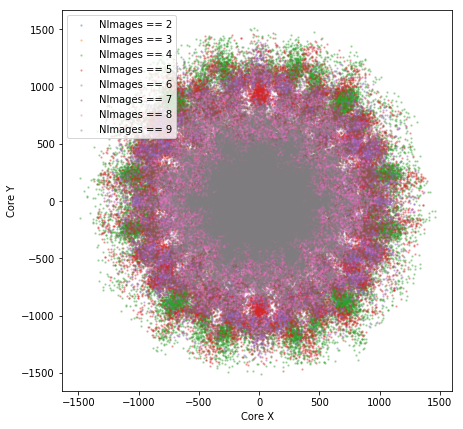

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[7, 7])
for i, n_images in enumerate([2, 3, 4, 5, 6, 7, 8, 9]):
#     ax = axs[int(np.floor(i/4)%4), i%4]
    # Multiplicity cut:
    multiplicity_cut = data.array('NImages') == n_images

    # Create data
    x_cores = data.array('Xcore')[np.logical_and(multiplicity_cut, gamma_like)]
    y_cores = data.array('Ycore')[np.logical_and(multiplicity_cut, gamma_like)]
    true_x_cores = data.array('MCxcore')[np.logical_and(multiplicity_cut, gamma_like)]
    true_y_cores = data.array('MCycore')[np.logical_and(multiplicity_cut, gamma_like)]
    # Plot
    ax.scatter(x_cores, y_cores, alpha=0.3, s=2, label="NImages == {}".format(n_images))
#     ax.set_title("Surviving with NImages == {}".format(n_images))
    ax.set_xlabel('Core X')
    ax.set_ylabel('Core Y')
#     ax.title('X/Y cores')
#     ax.xlabel('x')
#     ax.ylabel('y')
ax.legend()
plt.show()

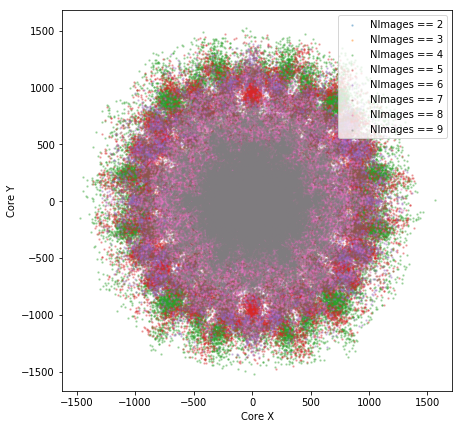

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[7, 7])
for i, n_images in enumerate([2, 3, 4, 5, 6, 7, 8, 9]):
#     ax = axs[int(np.floor(i/4)%4), i%4]
    # Multiplicity cut:
    multiplicity_cut = data.array('NImages') == n_images

    # Create data
    x_cores = data.array('MCxcore')[np.logical_and(multiplicity_cut, gamma_like)]
    y_cores = data.array('MCycore')[np.logical_and(multiplicity_cut, gamma_like)]

    # Plot
    ax.scatter(x_cores, y_cores, alpha=0.3, s=2, label="NImages == {}".format(n_images))
#     ax.set_title("Surviving with NImages == {}".format(n_images))
    ax.set_xlabel('Core X')
    ax.set_ylabel('Core Y')
#     ax.title('X/Y cores')
#     ax.xlabel('x')
#     ax.ylabel('y')
ax.legend()
plt.show()

In [133]:
# Code taken from: https://github.com/cta-observatory/protopipe/blob/master/protopipe/scripts/write_dl2.py

# this class defines the reconstruction parameters to keep track of
class RecoEvent(tb.IsDescription):
    obs_id = tb.Int16Col(dflt=-1, pos=0)
    event_id = tb.Int32Col(dflt=-1, pos=1)
    NTels_trig = tb.Int16Col(dflt=0, pos=2)
    NTels_reco = tb.Int16Col(dflt=0, pos=3)
    NTels_reco_lst = tb.Int16Col(dflt=0, pos=4)
    NTels_reco_mst = tb.Int16Col(dflt=0, pos=5)
    NTels_reco_sst = tb.Int16Col(dflt=0, pos=6)
    mc_energy = tb.Float32Col(dflt=np.nan, pos=7)
    reco_energy = tb.Float32Col(dflt=np.nan, pos=8)
    reco_alt = tb.Float32Col(dflt=np.nan, pos=9)
    reco_az = tb.Float32Col(dflt=np.nan, pos=10)
    offset = tb.Float32Col(dflt=np.nan, pos=11)
    xi = tb.Float32Col(dflt=np.nan, pos=12)
    ErrEstPos = tb.Float32Col(dflt=np.nan, pos=13)
    ErrEstDir = tb.Float32Col(dflt=np.nan, pos=14)
    gammaness = tb.Float32Col(dflt=np.nan, pos=15)
    success = tb.BoolCol(dflt=False, pos=16)
    score = tb.Float32Col(dflt=np.nan, pos=17)
    h_max = tb.Float32Col(dflt=np.nan, pos=18)
    reco_core_x = tb.Float32Col(dflt=np.nan, pos=19)
    reco_core_y = tb.Float32Col(dflt=np.nan, pos=20)
    mc_core_x = tb.Float32Col(dflt=np.nan, pos=21)
    mc_core_y = tb.Float32Col(dflt=np.nan, pos=22)

reco_outfile = tb.open_file(mode="w", filename = "outfile.h5", driver = "H5FD_CORE", driver_core_backing_store=False)
reco_table = reco_outfile.create_table("/", "reco_events", RecoEvent)
reco_event = reco_table.row


# Loop through first 1000 events:
for i in np.arange(0, 1000):
    # Fill table's attributes
    reco_event["NTels_trig"] = data["NTrig"][i]
    reco_event["NTels_reco"] = len(hillas_dict)
    reco_event["NTels_reco_lst"] = n_tels["LST"]
    reco_event["NTels_reco_mst"] = n_tels["MST"]
    reco_event["NTels_reco_sst"] = n_tels["SST"]
    reco_event["reco_energy"] = reco_energy
    reco_event["reco_alt"] = alt.to("deg").value
    reco_event["reco_az"] = az.to("deg").value
    reco_event["offset"] = offset.to("deg").value
    reco_event["xi"] = xi.to("deg").value
    reco_event["h_max"] = h_max.to("m").value
    reco_event["reco_core_x"] = reco_core_x.to("m").value
    reco_event["reco_core_y"] = reco_core_y.to("m").value
    reco_event["mc_core_x"] = mc_core_x.to("m").value
    reco_event["mc_core_y"] = mc_core_y.to("m").value
    if use_proba_for_classifier is True:
        reco_event["gammaness"] = gammaness
    else:
        reco_event["score"] = score
    reco_event["success"] = True
    reco_event["ErrEstPos"] = np.nan
    reco_event["ErrEstDir"] = np.nan

    # save basic event infos
    reco_event["mc_energy"] = event.mc.energy.to("TeV").value
    reco_event["event_id"] = event.r1.event_id
    reco_event["obs_id"] = event.r1.obs_id

# Fill table
reco_table.flush()
reco_event.append()

# make sure everything gets written out nicely
reco_table.flush()

Fill Event list dictionary
------------------

I extracted most of the event list code from V2DL3 and stored event info into a dictionary:

In [45]:
evt_dict = {}
# Filling Event List
evt_dict['EVENT_ID'] = event_id
evt_dict['OBS_ID'] = obs_id
# evt_dict['TIME'] = timeArr
# evt_dict['RA'] = raArr
# evt_dict['DEC'] = decArr
evt_dict['MC_ALT'] = mc_alt
evt_dict['MC_AZ'] = mc_az
evt_dict['MC_ENERGY'] = mc_energy
evt_dict['ALT'] = reco_alt
evt_dict['AZ'] = reco_az
evt_dict['ENERGY'] = reco_energy
evt_dict['MULTIP'] = NTels_reco

# evt_dict['EVENT_TYPE'] = nTelArr

In [46]:
# Filling Header info
evt_dict['ALT_PNT'] = pointing_elevation
evt_dict['AZ_PNT'] = pointing_azimuth
evt_dict['COREX'] = reco_core_x
evt_dict['COREY'] = reco_core_y
# evt_dict['COREX'] = reco_core_x
# evt_dict['COREY'] = reco_core_y
# evt_dict['TELLIST'] = produce_tel_list(telConfig)
# evt_dict['N_TELS'] = len(telConfig['TelID'])
# evt_dict['GEOLON'] = VTS_REFERENCE_LON
# evt_dict['GEOLAT'] = VTS_REFERENCE_LAT
evt_dict['ALTITUDE'] = 2150
evt_dict['B_FIELD'] = "215023.1177 microT (-22.7127,0)"

In [47]:
# obs_id = data.array("runNumber")               #     obs_id = tb.Int16Col(dflt=-1, pos=0)
# event_id = data.array("eventNumber")           #     event_id = tb.Int32Col(dflt=-1, pos=1)
# NTels_trig = data.array("NTrig")               #     NTels_trig = tb.Int16Col(dflt=0, pos=2)
# NTels_reco = data.array("NImages")             #     NTels_reco = tb.Int16Col(dflt=0, pos=3)
# NTels_reco_lst = [images_type[2] for images_type in data.array("NImages_Ttype")]      
#                                                #(2)  NTels_reco_lst = tb.Int16Col(dflt=0, pos=4)
# NTels_reco_mst = [images_type[1] for images_type in data.array("NImages_Ttype")]      
#                                                #(1)  NTels_reco_mst = tb.Int16Col(dflt=0, pos=5)
# NTels_reco_sst = [images_type[0] for images_type in data.array("NImages_Ttype")]      
#                                                #(0)  NTels_reco_sst = tb.Int16Col(dflt=0, pos=6)
# mc_energy = data.array("MCe0")                 #     mc_energy = tb.Float32Col(dflt=np.nan, pos=7)
# reco_energy = data.array("ErecS")              #     reco_energy = tb.Float32Col(dflt=np.nan, pos=8)
# mc_alt = 90 - data.array("MCze")
# mc_az = data.array("MCaz")
# reco_alt = 90 - data.array("Ze")               #     reco_alt = tb.Float32Col(dflt=np.nan, pos=9)
# reco_az = data.array("Az")                     #     reco_az = tb.Float32Col(dflt=np.nan, pos=10)

# pointing_elevation = data.array("ArrayPointing_Elevation")
# pointing_azimuth = data.array("ArrayPointing_Azimuth")

# # Angular separation bewteen the center of the camera and the reco direction.
# offset = angular_separation(                   #     offset = tb.Float32Col(dflt=np.nan, pos=11)
#     pointing_azimuth*u.deg,  # az
#     pointing_elevation*u.deg,  # alt
#     reco_az*u.deg,
#     reco_alt*u.deg,
# )

# xi = angular_separation(
#     mc_az*u.deg, mc_alt*u.deg, reco_az*u.deg, reco_alt*u.deg
# )
# # NTels_trig = data.array("NImages_Ttype")       #     ErrEstPos = tb.Float32Col(dflt=np.nan, pos=13)
# # NTels_trig = data.array("NImages_Ttype")       #     ErrEstDir = tb.Float32Col(dflt=np.nan, pos=14)
# # NTels_trig = data.array("NImages_Ttype")       #     gammaness = tb.Float32Col(dflt=np.nan, pos=15)
# # NTels_trig = data.array("NImages_Ttype")       #     success = tb.BoolCol(dflt=False, pos=16)
# # NTels_trig = data.array("NImages_Ttype")       #     score = tb.Float32Col(dflt=np.nan, pos=17)
# h_max = data.array("EmissionHeight")        #     h_max = tb.Float32Col(dflt=np.nan, pos=18)
# reco_core_x = data.array("Xcore")           #     reco_core_x = tb.Float32Col(dflt=np.nan, pos=19)
# reco_core_y = data.array("Ycore")           #     reco_core_y = tb.Float32Col(dflt=np.nan, pos=20)
# mc_core_x = data.array("MCxcore")           #     mc_core_x = tb.Float32Col(dflt=np.nan, pos=21)
# mc_core_y = data.array("MCycore")           #     mc_core_y = tb.Float32Col(dflt=np.nan, pos=22)

In [48]:
# Create primary HDU:
hdu0 = fits.PrimaryHDU()
hdu0.header.set('TELESCOP', 
                'CTA-S.3HB9-FD',
                'Telescope and array codename.')
# hdu0.header.set('LICENSE ',
#                 '',
#                 '')
hdu0.header['COMMENT'] = "FITS (Flexible Image Transport System) format is defined in 'Astronomy"
hdu0.header['COMMENT'] = "and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H"

In [49]:
# Create event list HDU:
# Columns to be saved
columns = [fits.Column(name='OBS_ID', format='1K', array=evt_dict['OBS_ID']),
           fits.Column(name='EVENT_ID', format='1K', array=evt_dict['EVENT_ID']),
#            fits.Column(name='TIME', format='1D', array=evt_dict['TIME'], unit="s"),
           fits.Column(name='MC_ALT', format='1E', array=evt_dict['MC_ALT'], unit="deg"),
           fits.Column(name='MC_AZ', format='1E', array=evt_dict['MC_AZ'], unit="deg"),
           fits.Column(name='MC_ENERGY', format='1E', array=evt_dict['MC_ENERGY'], unit="TeV"),
           fits.Column(name='ALT', format='1E', array=evt_dict['ALT'], unit="deg"),
           fits.Column(name='AZ', format='1E', array=evt_dict['AZ'], unit="deg"),
           # Not necessary for gammapy and spec
           # fits.Column(name='ALT', format='1E', array=evt_dict['ALT'], unit = "deg"),
           # fits.Column(name='AZ', format='1E', array=evt_dict['AZ'], unit = "deg"),
           fits.Column(name='ENERGY', format='1E', array=evt_dict['ENERGY'], unit="TeV"),
           fits.Column(name='MULTIP', format='1J', array=evt_dict['MULTIP'])
           ]

# Create HDU
hdu1 = fits.BinTableHDU.from_columns(columns)
hdu1.name = "EVENTS"

# For filling HDU headers
HDUCLASS = 'GADF' 
HDUDOC   = 'https://gamma-astro-data-formats.readthedocs.io'
HDUVERS  = '0.2' 
RADECSYS = 'FK5'

hdu1.header.set('HDUCLASS',HDUCLASS,'This FITS file follows the GADF data format')
hdu1.header.set('HDUDOC',HDUDOC)
hdu1.header.set('HDUVERS',HDUVERS,'DL3 specification version')
hdu1.header.set('HDUCLAS1','EVENTS','Primary extension class')     

# Fill Header
# hdu1.header.set('RADECSYS', RADECSYS, 'equatorial system type')
# hdu1.header.set('EQUINOX', EQUINOX, 'base equinox')
hdu1.header.set('CREATOR', 'eventDisplay v480')
hdu1.header.set('ORIGIN', 'CTA Collaboration', 'Data from VERITAS')
hdu1.header.set('TELESCOP', 'CTA-S.3HB9-FD')
# hdu1.header.set('INSTRUME', 'VERITAS')

# hdu1.header.set('OBS_ID  ', evt_dict['OBS_ID'], 'Run Number')

# hdu1.header.set('DATE-OBS',
#                 evt_dict['DATE-OBS'],
#                 'start date (UTC) of obs yy-mm-dd')
# hdu1.header.set('TIME-OBS',
#                 evt_dict['TIME-OBS'],
#                 'start time (UTC) of obs hh-mm-ss')
# hdu1.header.set('DATE-END',
#                 evt_dict['DATE-END'],
#                 'end date (UTC) of obs yy-mm-dd')
# hdu1.header.set('TIME-END',
#                 evt_dict['TIME-END'],
#                 'end time (UTC) of obs hh-mm-ss')

# hdu1.header.set('TSTART  ',
#                 evt_dict['TSTART'],
#                 'mission time of start of obs [s]')
# hdu1.header.set('TSTOP   ',
#                 evt_dict['TSTOP'],
#                 'mission time of end of obs [s]')
# hdu1.header.set('MJDREFI ',
#                 VTS_REFERENCE_MJD, 'int part of reference MJD [days]')
# hdu1.header.set('MJDREFF ', 0., 'fractional part of reference MJD [days]')

# hdu1.header.set('TIMEUNIT', 's', 'time unit is seconds since MET start')
# hdu1.header.set('TIMESYS ', 'utc', 'time scale is UTC')
# hdu1.header.set('TIMEREF ', 'local', 'local time reference')

# hdu1.header.set('ONTIME  ', 
#                 evt_dict['ONTIME'],
#                 'time on target (including deadtime)')

# Correct live time for time cuts
# hdu1.header.set('LIVETIME', evt_dict['LIVETIME'],
#                 '(dead=ONTIME-LIVETIME) [s] ')

# hdu1.header.set('DEADC   ', evt_dict['DEADC'],
#                 'Average dead time correction (LIVETIME/ONTIME)')

# hdu1.header.set('OBJECT  ', evt_dict['OBJECT'], 'observed object')
# hdu1.header.set('RA_OBJ  ',
#                 evt_dict['RA_OBJ'],
#                 'observation position RA [deg]')
# hdu1.header.set('DEC_OBJ ',
#                 evt_dict['DEC_OBJ'],
#                 'observation position DEC [deg]')

# hdu1.header.set('RA_PNT  ', evt_dict['RA_PNT'], 'observation position RA [deg]')
# hdu1.header.set('DEC_PNT ', evt_dict['DEC_PNT'], 'observation position DEC [deg]')
hdu1.header.set('ALT_PNT ', pointing_elevation[0], 'Average altitude of pointing [deg]')
hdu1.header.set('AZ_PNT  ', pointing_azimuth[0], 'Average azimuth of pointing [deg]')

# get the list of telescopes that participate in the event
# hdu1.header.set('TELLIST',
#                 evt_dict['TELLIST'],
#                 'comma-separated list of tel IDs')
# hdu1.header.set('N_TELS',evt_dict['N_TELS'],
#                 'number of telescopes in event list')

hdu1.header.set('EUNIT   ', 'TeV', 'energy unit')
# hdu1.header.set('GEOLON  ', VTS_REFERENCE_LON, 'longitude of array center [deg]')
# hdu1.header.set('GEOLAT  ', VTS_REFERENCE_LAT, 'latitude of array center [deg]')
hdu1.header.set('ALTITUDE', evt_dict['ALTITUDE'], 'Altitude of array center [m]')


In [53]:
# Store the histogram of simulated events vs MC_ENERGY
energy_low = np.power(10, bin_edges[0:-1])
energy_high = np.power(10, bin_edges[1:len(bin_edges)])
num_events = bin_content

x = np.array([(energy_low, energy_high, num_events)],
             dtype=[('MC_ENERG_LO', '>f4', np.shape(energy_low)),
                    ('MC_ENERG_HI', '>f4', np.shape(energy_high)),
                    ('EVENTS', '>f4', np.shape(num_events))])

hdu2 = fits.BinTableHDU(data=x)
hdu2.name = "SIMULATED EVENTS"
hdu2.header.set('TUNIT1 ', 'TeV', "")
hdu2.header.set('TUNIT2 ', 'TeV', "")
hdu2.header.set('TUNIT3 ', '', "")
hdu2.header.set('LO_THRES', np.power(10, min(bin_edges)),
                  'Low energy threshold of validity [TeV]')
hdu2.header.set('HI_THRES', np.power(10, max(bin_edges)),
                  'High energy threshold of validity [TeV]')
hdu2.header.set('CREF3', '(MC_ENERG_LO:MC_ENERG_HI)', '')

In [4]:
hdus = list()
hdus.append(hdu0)
hdus.append(hdu1)
hdus.append(hdu2)
hdulist = fits.HDUList(hdus)
hdulist.writeto("gamma_onSource.S.3HB9-FD_ID0.eff-0.fits", overwrite=True)

NameError: name 'hdu0' is not defined

## 

In [6]:
from astropy.io import fits
hdul = fits.open('/home/thassan/CTA/eventDisplay/gernot_DL2_files/gamma_onSource.S.3HB9-FD_ID0.eff-0.fits')
hdul.info()

Filename: /home/thassan/CTA/eventDisplay/gernot_DL2_files/gamma_onSource.S.3HB9-FD_ID0.eff-0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  EVENTS        1 BinTableHDU     44   549346R x 9C   [1K, 1K, 1E, 1E, 1E, 1E, 1E, 1E, 1J]   
  2  SIMULATED EVENTS    1 BinTableHDU     21   1R x 3C   [60E, 60E, 60E]   


In [11]:
data = hdul[2].data

In [12]:
data.columns

ColDefs(
    name = 'MC_ENERG_LO'; format = '60E'; unit = 'TeV'
    name = 'MC_ENERG_HI'; format = '60E'; unit = 'TeV'
    name = 'EVENTS'; format = '60E'
)

In [7]:
import time
import numpy as np
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

iris = datasets.load_iris()
X, y = iris.data, iris.target

X = np.repeat(X, 100, axis=0)
y = np.repeat(y, 100, axis=0)
start = time.time()
clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'))
clf.fit(X, y)
end = time.time()
print("Single SVC", end - start, clf.score(X,y))
proba = clf.predict_proba(X)

n_estimators = 10
start = time.time()
clf = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True, 
                                                class_weight='balanced'), 
                                            max_samples=1.0 / n_estimators, 
                                            n_estimators=n_estimators))
clf.fit(X, y)
end = time.time()
print("Bagging SVC", end - start, clf.score(X,y))
proba = clf.predict_proba(X)

start = time.time()
clf = RandomForestClassifier(min_samples_leaf=20)
clf.fit(X, y)
end = time.time()
print("Random Forest", end - start, clf.score(X,y))
proba = clf.predict_proba(X)

Single SVC 22.286093950271606 0.9666666666666667
Bagging SVC 1.686769723892212 0.96
Random Forest 0.24794626235961914 1.0
